# Project 2: A Comparison of Architectures Feature Extraction and Classification Performance Fully Connected ANNs vs CNN using MNIST and fashionMNIST [composed with Keras]

In [17]:
!pip install -U "portalocker>=2.0.0"

# Import necessary packages

In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
import numpy as np

# Task - 1

We’re going to start out on the MNIST dataset using a state of the art NN framework. The
optimizers and speed of the these methods will far outpace the basic python versions you used in the
last experiment.

## Hidden Layer Nodes
Using a procedural* search adjust the values for the number of elements in the network’s hidden layers and observe the relative performance of each configuration.

[This will impact the number of weights, and the complexity of the decision surface the network can approximate.](*this can be purely incremental or some form of iterative optimization
employing a meta-analysis of the architecture)

➢ Select at least 5 different values for the number of hidden nodes per layer. (It’s best if these change by some value like 10,20, or 30 for more obvious impact)

➢ (Suggested) You can choose to implement this the number of layers at the same time.
## Number of Layers 
The framework for the model provided in the notebook contains 2 hidden layers. Modify both the layer number and node number (in some scientific way) to determine the minimal complexity needed to achieve at least 90% accuracy.

➢ Add no more than one hidden layer at a time and iterate through the number of nodes for each layer procedurally – you should be able to easily produce results for 15-20 configurations (train for ~25-50 epochs)
## Optimizer
select another optimization function and adjust the relevant parameters

➢ Try at least 5 different parameter settings (lr,decay,reg)

➢ (Suggested) Implement some form of momentum optimization

In [19]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
batch_size = 64  # Define batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

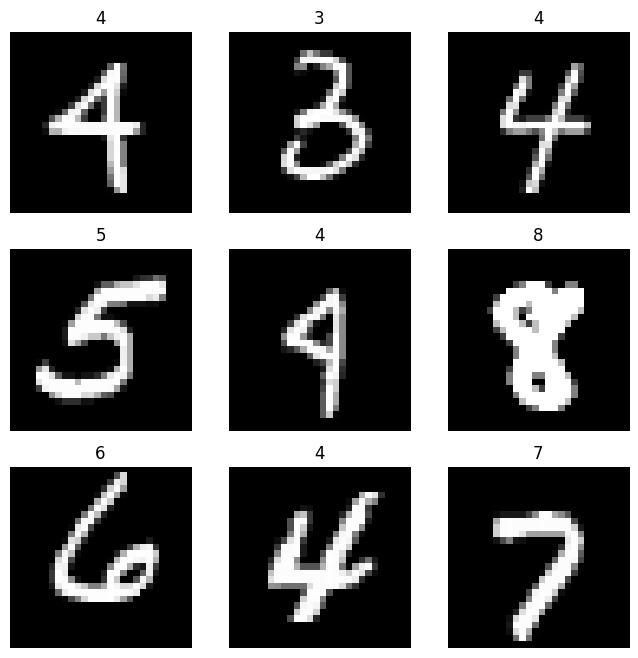

In [21]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [22]:
# Define a Multi-Layer Perceptron (MLP) model with customizable layers and nodes
class MLP(nn.Module):
    def __init__(self, layer_nodes):
        super(MLP, self).__init__()
        layers = []
        input_size = 28 * 28  # Input size is 28x28 images
        for nodes in layer_nodes:
            layers.append(nn.Linear(input_size, nodes))  # Add fully connected layers
            layers.append(nn.ReLU())  # Use ReLU activation
            input_size = nodes
        layers.append(nn.Linear(input_size, 10))  # Final layer for 10 output classes
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        return self.network(x)

In [23]:
# Function to train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0
    print('Training Finished')
    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')
    return accuracy

In [113]:
# Experiment configurations
experiments = [
    {'layers': [32, 16], 'optimizer': 'SGD', 'lr': 0.002, 'epochs': 35},
    {'layers': [64, 32], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 25},
    {'layers': [128, 64], 'optimizer': 'RMSprop', 'lr': 0.0005, 'epochs': 40},
    {'layers': [64, 32, 16], 'optimizer': 'SGD', 'lr': 0.001, 'epochs': 50},
    {'layers': [128, 64, 32], 'optimizer': 'Adam', 'lr': 0.0002, 'epochs': 35},
    {'layers': [256, 128], 'optimizer': 'RMSprop', 'lr': 0.0001, 'epochs': 45},
    {'layers': [32, 32], 'optimizer': 'SGD', 'lr': 0.01, 'epochs': 30},
    {'layers': [64, 64], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 25},
    {'layers': [128, 128], 'optimizer': 'RMSprop', 'lr': 0.0005, 'epochs': 40},
    {'layers': [256, 128, 64], 'optimizer': 'SGD', 'lr': 0.001, 'epochs': 50},
    {'layers': [512, 256], 'optimizer': 'Adam', 'lr': 0.0001, 'epochs': 30},
    {'layers': [32, 16, 8], 'optimizer': 'RMSprop', 'lr': 0.002, 'epochs': 45},
    {'layers': [64, 32, 16], 'optimizer': 'SGD', 'lr': 0.0004, 'epochs': 70},
    {'layers': [128, 64, 32], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 50},
    {'layers': [256, 128, 64], 'optimizer': 'RMSprop', 'lr': 0.0002, 'epochs': 30}
]

In [114]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Experiment', 'Layers', 'Hidden Layer Sizes', 'Training Data Division', 
                                   'Batch Size', 'Learning Rate', 'Optimizer', 'Accuracy'])


Running Experiment 1 with Layers: [32, 16], Optimizer: SGD, Epochs: 35
Epoch 1, Batch 100, Loss: 2.2980584192276
Epoch 1, Batch 200, Loss: 2.250192039012909
Epoch 1, Batch 300, Loss: 2.1980079889297484
Epoch 1, Batch 400, Loss: 2.16523656129837
Epoch 1, Batch 500, Loss: 2.112065204381943
Epoch 1, Batch 600, Loss: 2.0611410188674926
Epoch 1, Batch 700, Loss: 2.002471331357956
Epoch 1, Batch 800, Loss: 1.944534456729889
Epoch 1, Batch 900, Loss: 1.8705958902835846
Epoch 2, Batch 100, Loss: 1.7525312066078187
Epoch 2, Batch 200, Loss: 1.6806050276756286
Epoch 2, Batch 300, Loss: 1.582678815126419
Epoch 2, Batch 400, Loss: 1.483496094942093
Epoch 2, Batch 500, Loss: 1.3801813232898712
Epoch 2, Batch 600, Loss: 1.2736409151554107
Epoch 2, Batch 700, Loss: 1.193313978910446
Epoch 2, Batch 800, Loss: 1.1246748238801956
Epoch 2, Batch 900, Loss: 1.0606484407186507
Epoch 3, Batch 100, Loss: 0.9733377212285995
Epoch 3, Batch 200, Loss: 0.94435999751091
Epoch 3, Batch 300, Loss: 0.89228483736515

/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_94863/400706644.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


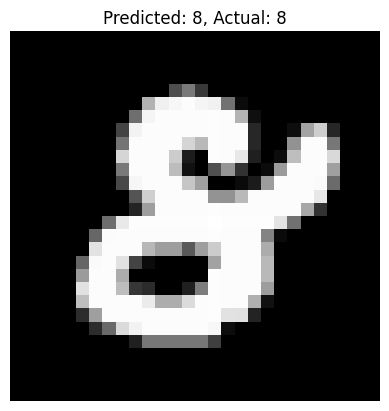


Running Experiment 2 with Layers: [64, 32], Optimizer: Adam, Epochs: 25
Epoch 1, Batch 100, Loss: 1.1952584025263786
Epoch 1, Batch 200, Loss: 0.5064231991767884
Epoch 1, Batch 300, Loss: 0.43724664598703383
Epoch 1, Batch 400, Loss: 0.3942074155807495
Epoch 1, Batch 500, Loss: 0.346552729010582
Epoch 1, Batch 600, Loss: 0.35330672055482865
Epoch 1, Batch 700, Loss: 0.3239826099574566
Epoch 1, Batch 800, Loss: 0.31902799718081953
Epoch 1, Batch 900, Loss: 0.3093321845680475
Epoch 2, Batch 100, Loss: 0.28747638694941996
Epoch 2, Batch 200, Loss: 0.26269786145538093
Epoch 2, Batch 300, Loss: 0.2628192304074764
Epoch 2, Batch 400, Loss: 0.2746711452305317
Epoch 2, Batch 500, Loss: 0.24878296464681626
Epoch 2, Batch 600, Loss: 0.2516028105467558
Epoch 2, Batch 700, Loss: 0.2362889163196087
Epoch 2, Batch 800, Loss: 0.22525803450495005
Epoch 2, Batch 900, Loss: 0.2271326519548893
Epoch 3, Batch 100, Loss: 0.19773906406015157
Epoch 3, Batch 200, Loss: 0.20032251067459583
Epoch 3, Batch 300,

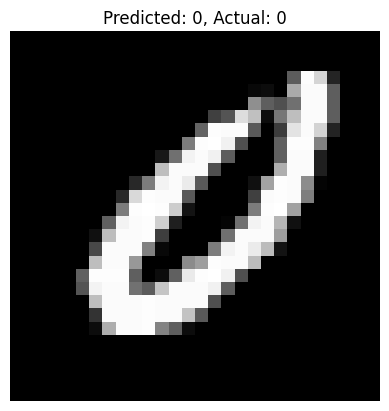


Running Experiment 3 with Layers: [128, 64], Optimizer: RMSprop, Epochs: 40
Epoch 1, Batch 100, Loss: 1.0300077357888222
Epoch 1, Batch 200, Loss: 0.4869075694680214
Epoch 1, Batch 300, Loss: 0.4237531453371048
Epoch 1, Batch 400, Loss: 0.3660647878050804
Epoch 1, Batch 500, Loss: 0.35063828855752943
Epoch 1, Batch 600, Loss: 0.33978554502129554
Epoch 1, Batch 700, Loss: 0.3195801596343517
Epoch 1, Batch 800, Loss: 0.3127643636614084
Epoch 1, Batch 900, Loss: 0.29810464560985567
Epoch 2, Batch 100, Loss: 0.26793550588190557
Epoch 2, Batch 200, Loss: 0.277802120372653
Epoch 2, Batch 300, Loss: 0.23064725197851657
Epoch 2, Batch 400, Loss: 0.2380736618489027
Epoch 2, Batch 500, Loss: 0.22392871372401715
Epoch 2, Batch 600, Loss: 0.21967729285359383
Epoch 2, Batch 700, Loss: 0.212637303173542
Epoch 2, Batch 800, Loss: 0.2113589858263731
Epoch 2, Batch 900, Loss: 0.20030264176428317
Epoch 3, Batch 100, Loss: 0.1818828833848238
Epoch 3, Batch 200, Loss: 0.1888672151044011
Epoch 3, Batch 30

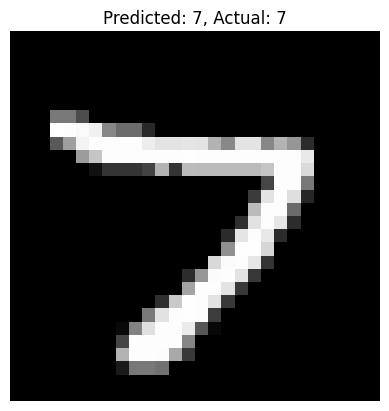


Running Experiment 4 with Layers: [64, 32, 16], Optimizer: SGD, Epochs: 50
Epoch 1, Batch 100, Loss: 2.303615005016327
Epoch 1, Batch 200, Loss: 2.302881917953491
Epoch 1, Batch 300, Loss: 2.3045322108268738
Epoch 1, Batch 400, Loss: 2.297300629615784
Epoch 1, Batch 500, Loss: 2.294084196090698
Epoch 1, Batch 600, Loss: 2.291976976394653
Epoch 1, Batch 700, Loss: 2.291501007080078
Epoch 1, Batch 800, Loss: 2.2861092257499696
Epoch 1, Batch 900, Loss: 2.28255882024765
Epoch 2, Batch 100, Loss: 2.2767093443870543
Epoch 2, Batch 200, Loss: 2.2746702098846434
Epoch 2, Batch 300, Loss: 2.2689369750022887
Epoch 2, Batch 400, Loss: 2.264186816215515
Epoch 2, Batch 500, Loss: 2.2588534474372866
Epoch 2, Batch 600, Loss: 2.257180030345917
Epoch 2, Batch 700, Loss: 2.2515355467796327
Epoch 2, Batch 800, Loss: 2.2496716499328615
Epoch 2, Batch 900, Loss: 2.242050187587738
Epoch 3, Batch 100, Loss: 2.2347461700439455
Epoch 3, Batch 200, Loss: 2.2264895629882813
Epoch 3, Batch 300, Loss: 2.2235805

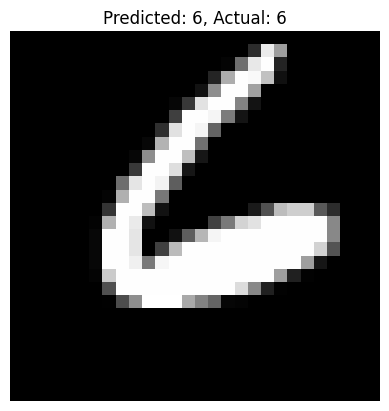


Running Experiment 5 with Layers: [128, 64, 32], Optimizer: Adam, Epochs: 35
Epoch 1, Batch 100, Loss: 2.0771566367149354
Epoch 1, Batch 200, Loss: 1.2919057697057723
Epoch 1, Batch 300, Loss: 0.8307893598079681
Epoch 1, Batch 400, Loss: 0.6827331486344338
Epoch 1, Batch 500, Loss: 0.5545213401317597
Epoch 1, Batch 600, Loss: 0.512460651397705
Epoch 1, Batch 700, Loss: 0.47217110902070997
Epoch 1, Batch 800, Loss: 0.43203409627079964
Epoch 1, Batch 900, Loss: 0.4223966820538044
Epoch 2, Batch 100, Loss: 0.3964242158830166
Epoch 2, Batch 200, Loss: 0.3626347655057907
Epoch 2, Batch 300, Loss: 0.34978569105267526
Epoch 2, Batch 400, Loss: 0.34351701438426974
Epoch 2, Batch 500, Loss: 0.3426666785031557
Epoch 2, Batch 600, Loss: 0.33852298781275747
Epoch 2, Batch 700, Loss: 0.3262520986795425
Epoch 2, Batch 800, Loss: 0.32032843299210073
Epoch 2, Batch 900, Loss: 0.31226208254694937
Epoch 3, Batch 100, Loss: 0.3004377181828022
Epoch 3, Batch 200, Loss: 0.28494218960404394
Epoch 3, Batch 

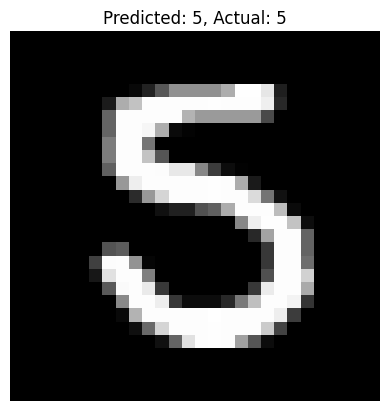


Running Experiment 6 with Layers: [256, 128], Optimizer: RMSprop, Epochs: 45
Epoch 1, Batch 100, Loss: 1.254744958281517
Epoch 1, Batch 200, Loss: 0.6417692503333092
Epoch 1, Batch 300, Loss: 0.516664177775383
Epoch 1, Batch 400, Loss: 0.450174557864666
Epoch 1, Batch 500, Loss: 0.4073183506727219
Epoch 1, Batch 600, Loss: 0.4006414447724819
Epoch 1, Batch 700, Loss: 0.36339235872030257
Epoch 1, Batch 800, Loss: 0.3555735090374947
Epoch 1, Batch 900, Loss: 0.35696775779128076
Epoch 2, Batch 100, Loss: 0.33101706705987455
Epoch 2, Batch 200, Loss: 0.31518560022115705
Epoch 2, Batch 300, Loss: 0.31900728955864904
Epoch 2, Batch 400, Loss: 0.2928867245465517
Epoch 2, Batch 500, Loss: 0.2943379674851894
Epoch 2, Batch 600, Loss: 0.2856401702016592
Epoch 2, Batch 700, Loss: 0.2980091095715761
Epoch 2, Batch 800, Loss: 0.2870597595721483
Epoch 2, Batch 900, Loss: 0.2892037477344275
Epoch 3, Batch 100, Loss: 0.2630208047479391
Epoch 3, Batch 200, Loss: 0.264844428896904
Epoch 3, Batch 300, L

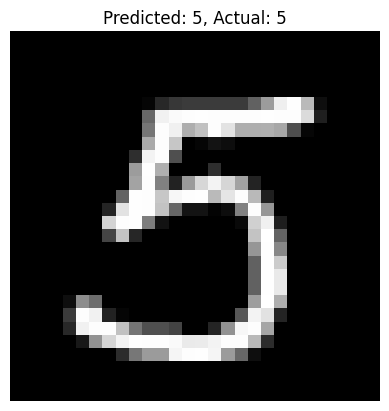


Running Experiment 7 with Layers: [32, 32], Optimizer: SGD, Epochs: 30
Epoch 1, Batch 100, Loss: 2.250820791721344
Epoch 1, Batch 200, Loss: 2.033448188304901
Epoch 1, Batch 300, Loss: 1.612376104593277
Epoch 1, Batch 400, Loss: 1.1550725620985032
Epoch 1, Batch 500, Loss: 0.875929543375969
Epoch 1, Batch 600, Loss: 0.717901371717453
Epoch 1, Batch 700, Loss: 0.6222658982872963
Epoch 1, Batch 800, Loss: 0.5596488538384438
Epoch 1, Batch 900, Loss: 0.5339021408557891
Epoch 2, Batch 100, Loss: 0.46944427013397216
Epoch 2, Batch 200, Loss: 0.4806254169344902
Epoch 2, Batch 300, Loss: 0.42761726647615433
Epoch 2, Batch 400, Loss: 0.40151860028505326
Epoch 2, Batch 500, Loss: 0.4078764808177948
Epoch 2, Batch 600, Loss: 0.41320548132061957
Epoch 2, Batch 700, Loss: 0.4011068759858608
Epoch 2, Batch 800, Loss: 0.3822501680254936
Epoch 2, Batch 900, Loss: 0.36337964221835134
Epoch 3, Batch 100, Loss: 0.36346169710159304
Epoch 3, Batch 200, Loss: 0.36266825541853903
Epoch 3, Batch 300, Loss: 

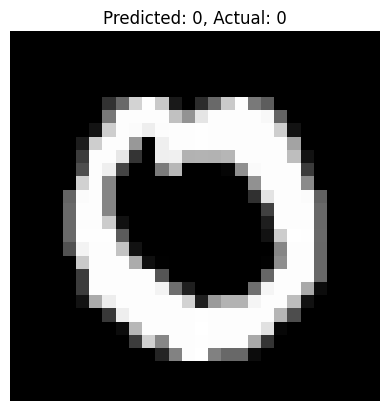


Running Experiment 8 with Layers: [64, 64], Optimizer: Adam, Epochs: 25
Epoch 1, Batch 100, Loss: 1.1782374343276023
Epoch 1, Batch 200, Loss: 0.48693838715553284
Epoch 1, Batch 300, Loss: 0.40493070214986804
Epoch 1, Batch 400, Loss: 0.3794813713431358
Epoch 1, Batch 500, Loss: 0.3538494399189949
Epoch 1, Batch 600, Loss: 0.3322792337834835
Epoch 1, Batch 700, Loss: 0.2846157769858837
Epoch 1, Batch 800, Loss: 0.2876430720835924
Epoch 1, Batch 900, Loss: 0.28349777005612853
Epoch 2, Batch 100, Loss: 0.2511830893158913
Epoch 2, Batch 200, Loss: 0.23375647366046906
Epoch 2, Batch 300, Loss: 0.21534338600933553
Epoch 2, Batch 400, Loss: 0.2393910828232765
Epoch 2, Batch 500, Loss: 0.21533121339976788
Epoch 2, Batch 600, Loss: 0.2377089909464121
Epoch 2, Batch 700, Loss: 0.23661478906869887
Epoch 2, Batch 800, Loss: 0.23221918404102326
Epoch 2, Batch 900, Loss: 0.2015702508762479
Epoch 3, Batch 100, Loss: 0.18957278244197368
Epoch 3, Batch 200, Loss: 0.17454550664871932
Epoch 3, Batch 30

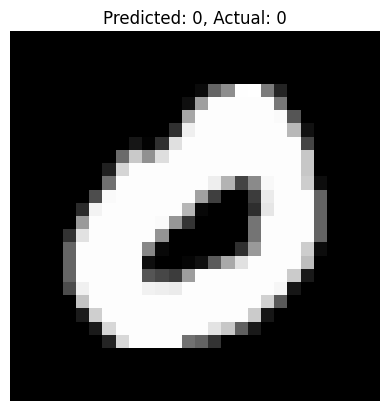


Running Experiment 9 with Layers: [128, 128], Optimizer: RMSprop, Epochs: 40
Epoch 1, Batch 100, Loss: 0.9715842470526695
Epoch 1, Batch 200, Loss: 0.46789770394563673
Epoch 1, Batch 300, Loss: 0.40108932435512545
Epoch 1, Batch 400, Loss: 0.35660431295633316
Epoch 1, Batch 500, Loss: 0.34731129989027976
Epoch 1, Batch 600, Loss: 0.3230350736528635
Epoch 1, Batch 700, Loss: 0.29500174187123773
Epoch 1, Batch 800, Loss: 0.2920952197164297
Epoch 1, Batch 900, Loss: 0.2647485610097647
Epoch 2, Batch 100, Loss: 0.23682684421539307
Epoch 2, Batch 200, Loss: 0.24088893309235573
Epoch 2, Batch 300, Loss: 0.22728485658764838
Epoch 2, Batch 400, Loss: 0.22785406097769736
Epoch 2, Batch 500, Loss: 0.22357175789773465
Epoch 2, Batch 600, Loss: 0.2058401468023658
Epoch 2, Batch 700, Loss: 0.21100634165108204
Epoch 2, Batch 800, Loss: 0.20726364850997925
Epoch 2, Batch 900, Loss: 0.18826693136245012
Epoch 3, Batch 100, Loss: 0.17419391531497241
Epoch 3, Batch 200, Loss: 0.16891321428120137
Epoch 3

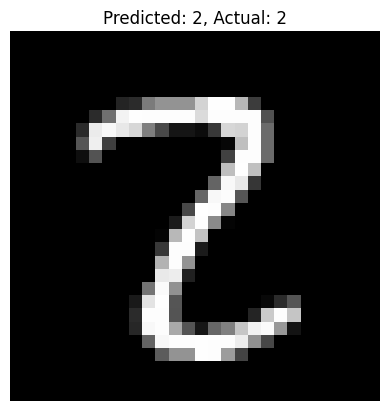


Running Experiment 10 with Layers: [256, 128, 64], Optimizer: SGD, Epochs: 50
Epoch 1, Batch 100, Loss: 2.303179748058319
Epoch 1, Batch 200, Loss: 2.29951468706131
Epoch 1, Batch 300, Loss: 2.2966535687446594
Epoch 1, Batch 400, Loss: 2.2908797240257264
Epoch 1, Batch 500, Loss: 2.2885372400283814
Epoch 1, Batch 600, Loss: 2.2845852160453797
Epoch 1, Batch 700, Loss: 2.2821682119369506
Epoch 1, Batch 800, Loss: 2.2794694900512695
Epoch 1, Batch 900, Loss: 2.2740609455108642
Epoch 2, Batch 100, Loss: 2.2689149522781373
Epoch 2, Batch 200, Loss: 2.2637004375457765
Epoch 2, Batch 300, Loss: 2.260103781223297
Epoch 2, Batch 400, Loss: 2.257126100063324
Epoch 2, Batch 500, Loss: 2.2489212369918823
Epoch 2, Batch 600, Loss: 2.245239119529724
Epoch 2, Batch 700, Loss: 2.2369720768928527
Epoch 2, Batch 800, Loss: 2.231160674095154
Epoch 2, Batch 900, Loss: 2.2231189894676207
Epoch 3, Batch 100, Loss: 2.212302494049072
Epoch 3, Batch 200, Loss: 2.205798451900482
Epoch 3, Batch 300, Loss: 2.19

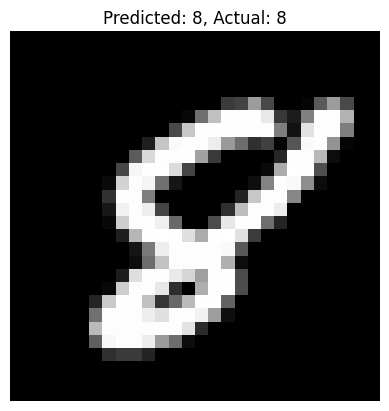


Running Experiment 11 with Layers: [512, 256], Optimizer: Adam, Epochs: 30
Epoch 1, Batch 100, Loss: 1.5645583027601242
Epoch 1, Batch 200, Loss: 0.6448420509696007
Epoch 1, Batch 300, Loss: 0.45965045869350435
Epoch 1, Batch 400, Loss: 0.39716362208127975
Epoch 1, Batch 500, Loss: 0.3766887132823467
Epoch 1, Batch 600, Loss: 0.3545414543151855
Epoch 1, Batch 700, Loss: 0.3512710078060627
Epoch 1, Batch 800, Loss: 0.3145694278180599
Epoch 1, Batch 900, Loss: 0.3081282434612513
Epoch 2, Batch 100, Loss: 0.27899040207266806
Epoch 2, Batch 200, Loss: 0.30352191962301733
Epoch 2, Batch 300, Loss: 0.2546332573890686
Epoch 2, Batch 400, Loss: 0.26820294216275214
Epoch 2, Batch 500, Loss: 0.23919764995574952
Epoch 2, Batch 600, Loss: 0.2406030760705471
Epoch 2, Batch 700, Loss: 0.2229937582463026
Epoch 2, Batch 800, Loss: 0.2275730850547552
Epoch 2, Batch 900, Loss: 0.20034725047647953
Epoch 3, Batch 100, Loss: 0.2165526584535837
Epoch 3, Batch 200, Loss: 0.20771205600351095
Epoch 3, Batch 3

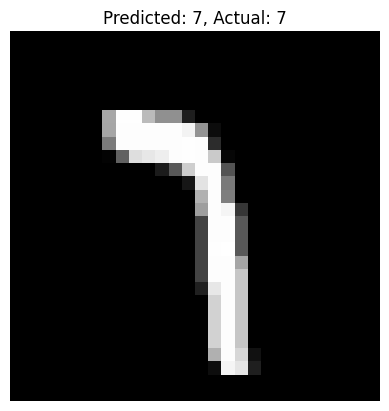


Running Experiment 12 with Layers: [32, 16, 8], Optimizer: RMSprop, Epochs: 45
Epoch 1, Batch 100, Loss: 1.9098174667358399
Epoch 1, Batch 200, Loss: 1.1216952168941499
Epoch 1, Batch 300, Loss: 0.8846040898561478
Epoch 1, Batch 400, Loss: 0.7523039248585701
Epoch 1, Batch 500, Loss: 0.6435121610760689
Epoch 1, Batch 600, Loss: 0.5483853396773338
Epoch 1, Batch 700, Loss: 0.5090375147759915
Epoch 1, Batch 800, Loss: 0.4561204288899898
Epoch 1, Batch 900, Loss: 0.4179418320953846
Epoch 2, Batch 100, Loss: 0.3849767863750458
Epoch 2, Batch 200, Loss: 0.38960100084543225
Epoch 2, Batch 300, Loss: 0.351584806740284
Epoch 2, Batch 400, Loss: 0.347390458136797
Epoch 2, Batch 500, Loss: 0.3391297841817141
Epoch 2, Batch 600, Loss: 0.35238748095929623
Epoch 2, Batch 700, Loss: 0.3227785390615463
Epoch 2, Batch 800, Loss: 0.3115274298936129
Epoch 2, Batch 900, Loss: 0.3150638492405415
Epoch 3, Batch 100, Loss: 0.2927355136722326
Epoch 3, Batch 200, Loss: 0.27747305780649184
Epoch 3, Batch 300,

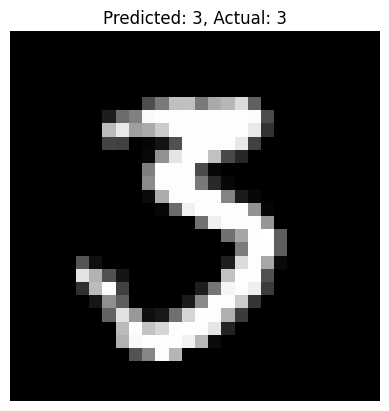


Running Experiment 13 with Layers: [64, 32, 16], Optimizer: SGD, Epochs: 70
Epoch 1, Batch 100, Loss: 2.313867616653442
Epoch 1, Batch 200, Loss: 2.3153683662414553
Epoch 1, Batch 300, Loss: 2.311183910369873
Epoch 1, Batch 400, Loss: 2.3110879778862
Epoch 1, Batch 500, Loss: 2.3097360920906067
Epoch 1, Batch 600, Loss: 2.310667221546173
Epoch 1, Batch 700, Loss: 2.3073785281181336
Epoch 1, Batch 800, Loss: 2.307347979545593
Epoch 1, Batch 900, Loss: 2.306384129524231
Epoch 2, Batch 100, Loss: 2.3035210371017456
Epoch 2, Batch 200, Loss: 2.304912989139557
Epoch 2, Batch 300, Loss: 2.3047663736343384
Epoch 2, Batch 400, Loss: 2.303388195037842
Epoch 2, Batch 500, Loss: 2.301077516078949
Epoch 2, Batch 600, Loss: 2.299167883396149
Epoch 2, Batch 700, Loss: 2.300546796321869
Epoch 2, Batch 800, Loss: 2.301290605068207
Epoch 2, Batch 900, Loss: 2.3012488651275635
Epoch 3, Batch 100, Loss: 2.301305899620056
Epoch 3, Batch 200, Loss: 2.298642838001251
Epoch 3, Batch 300, Loss: 2.29650772809

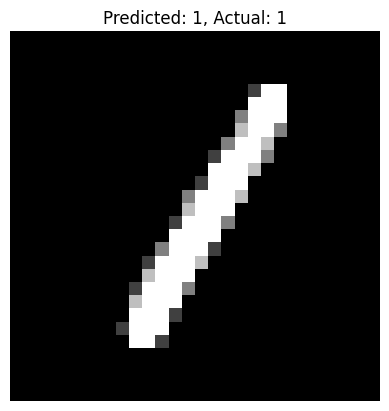


Running Experiment 14 with Layers: [128, 64, 32], Optimizer: Adam, Epochs: 50
Epoch 1, Batch 100, Loss: 1.256855128109455
Epoch 1, Batch 200, Loss: 0.4945035883784294
Epoch 1, Batch 300, Loss: 0.43080134510993956
Epoch 1, Batch 400, Loss: 0.3904971797764301
Epoch 1, Batch 500, Loss: 0.35981801331043245
Epoch 1, Batch 600, Loss: 0.3168986751139164
Epoch 1, Batch 700, Loss: 0.31994699612259864
Epoch 1, Batch 800, Loss: 0.2849651386588812
Epoch 1, Batch 900, Loss: 0.28923367001116274
Epoch 2, Batch 100, Loss: 0.23211249954998492
Epoch 2, Batch 200, Loss: 0.22892918273806573
Epoch 2, Batch 300, Loss: 0.24778057340532542
Epoch 2, Batch 400, Loss: 0.2169072163850069
Epoch 2, Batch 500, Loss: 0.20032888665795326
Epoch 2, Batch 600, Loss: 0.20686126675456762
Epoch 2, Batch 700, Loss: 0.18650304079055785
Epoch 2, Batch 800, Loss: 0.18116166323423386
Epoch 2, Batch 900, Loss: 0.18136524815112354
Epoch 3, Batch 100, Loss: 0.14853465426713228
Epoch 3, Batch 200, Loss: 0.15097110752016307
Epoch 3,

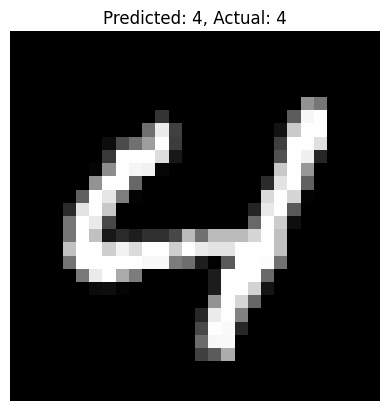


Running Experiment 15 with Layers: [256, 128, 64], Optimizer: RMSprop, Epochs: 30
Epoch 1, Batch 100, Loss: 1.2461604833602906
Epoch 1, Batch 200, Loss: 0.6156742089986801
Epoch 1, Batch 300, Loss: 0.49973609030246735
Epoch 1, Batch 400, Loss: 0.44242495864629744
Epoch 1, Batch 500, Loss: 0.4123673985898495
Epoch 1, Batch 600, Loss: 0.36536367282271387
Epoch 1, Batch 700, Loss: 0.3521483273804188
Epoch 1, Batch 800, Loss: 0.3316661855578423
Epoch 1, Batch 900, Loss: 0.341234540194273
Epoch 2, Batch 100, Loss: 0.3045106093585491
Epoch 2, Batch 200, Loss: 0.2894409030675888
Epoch 2, Batch 300, Loss: 0.28210433036088944
Epoch 2, Batch 400, Loss: 0.2799816285818815
Epoch 2, Batch 500, Loss: 0.27346410416066647
Epoch 2, Batch 600, Loss: 0.24862905848771333
Epoch 2, Batch 700, Loss: 0.24112498037517072
Epoch 2, Batch 800, Loss: 0.24389392808079718
Epoch 2, Batch 900, Loss: 0.2544561033695936
Epoch 3, Batch 100, Loss: 0.23146080724895002
Epoch 3, Batch 200, Loss: 0.21675600178539753
Epoch 3,

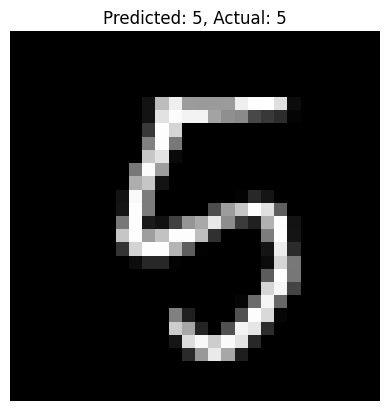

In [115]:
# Run each experiment and record the results
for idx, config in enumerate(experiments):
    print(f"\nRunning Experiment {idx + 1} with Layers: {config['layers']}, Optimizer: {config['optimizer']}, Epochs: {config['epochs']}")

    # Initialize the model
    model = MLP(config['layers'])

    # Initialize the optimizer
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    accuracy = train_and_evaluate(model, optimizer, criterion, num_epochs=config['epochs'])

    # Get hidden layer sizes as a string for recording
    hidden_layer_sizes = ', '.join([str(layer) for layer in config['layers']])

    # Record the results, including hidden layer sizes and other requested details
    results_df = pd.concat([results_df, pd.DataFrame({
        'Experiment': [f'Experiment {idx + 1}'],
        'Layers': [len(config['layers'])],
        'Hidden Layer Sizes': [hidden_layer_sizes],
        'Training Data Division': ['60,000 Training / 10,000 Testing'],
        'Batch Size': [batch_size],
        'Learning Rate': [config['lr']],
        'Optimizer': [config['optimizer']],
        'Accuracy': [accuracy * 100]
    })], ignore_index=True)


    # Display a sample prediction using labels_map
    image_index = torch.randint(len(test_dataset), size=(1,)).item()
    test_image, test_label = test_dataset[image_index]

    with torch.no_grad():
        model.eval()
        output = model(test_image.unsqueeze(0))
        _, predicted_label = torch.max(output, 1)

    test_image_numpy = test_image.squeeze().numpy()

    plt.imshow(test_image_numpy, cmap='gray')
    plt.title(f'Predicted: {labels_map[predicted_label.item()]}, Actual: {labels_map[test_label]}')
    plt.axis('off')
    plt.show()

In [116]:
# Display the experiment results table
print("\nExperiment Results Table:")
print(results_df)

# Save the results as an Excel file
results_df.to_excel('results1.xlsx', index=False)


Experiment Results Table:
       Experiment Layers Hidden Layer Sizes            Training Data Division  \
0    Experiment 1      2             32, 16  60,000 Training / 10,000 Testing   
1    Experiment 2      2             64, 32  60,000 Training / 10,000 Testing   
2    Experiment 3      2            128, 64  60,000 Training / 10,000 Testing   
3    Experiment 4      3         64, 32, 16  60,000 Training / 10,000 Testing   
4    Experiment 5      3        128, 64, 32  60,000 Training / 10,000 Testing   
5    Experiment 6      2           256, 128  60,000 Training / 10,000 Testing   
6    Experiment 7      2             32, 32  60,000 Training / 10,000 Testing   
7    Experiment 8      2             64, 64  60,000 Training / 10,000 Testing   
8    Experiment 9      2           128, 128  60,000 Training / 10,000 Testing   
9   Experiment 10      3       256, 128, 64  60,000 Training / 10,000 Testing   
10  Experiment 11      2           512, 256  60,000 Training / 10,000 Testing   
1

# Task - 2

We’re going to start out on the FashionMNIST dataset using a state of the art NN framework.
Using a dataset FMNIST, the complexity of the data increased so does the architecture must be.
Observe your performance and be ready to compare the results of your models to the same dataset
using a CNN in Part 2.

## Hidden Layer Nodes
Using a procedural* search adjust the values for the number of elements in the
network’s hidden layers and observe the relative performance of eachconfiguration.

[This will impact the number of weights, and the complexity of the decision
surface the network can approximate.]

(*this can be purely incremental or some form of iterative optimization
employing a meta-analysis of the architecture)

➢ Select at least 5 different values for the number of hidden nodes per
layer. (It’s best if these change by some value like 10,20, or 30 for more
obvious impact)

➢ (Suggested) You can choose to implement this the number of layers at
the same time.
## Number of Layers
The framework for the model provided in the notebook contains 2 hidden layers. Modify both the layer number and node number (in some scientific way) to determine the minimal complexity needed to achieve at least 85% accuracy.

➢ Add no more than one hidden layer at a time and iterate through the number of nodes for each layer procedurally – you should be able to easily produce results for 20-30 configurations (train for ~25-50 epochs)
## Optimizer 
select another optimization function and adjust the relevant parameters

➢ Try at least 5 different parameter settings (lr,decay,reg)

➢ (Suggested) Implement some form of momentum optimization

In [3]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
batch_size = 64  # Define batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:06<00:00, 4150896.60it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 255494.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 919394.72it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17399095.08it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

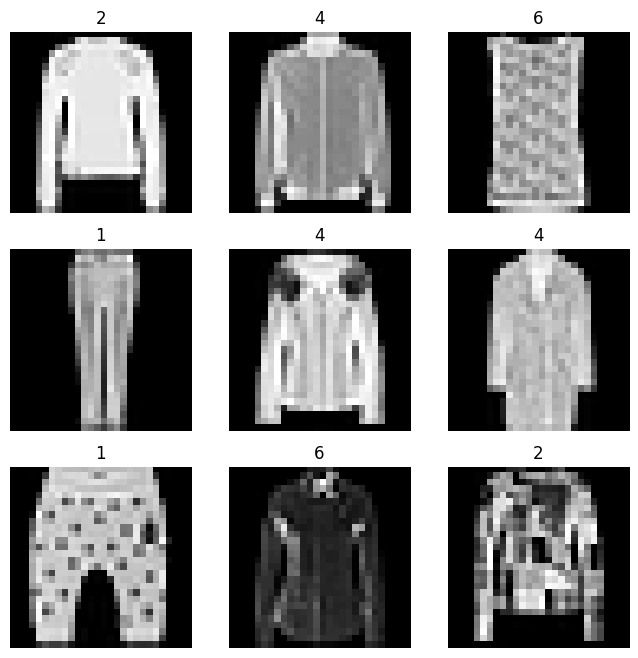

In [5]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, layer_nodes):
        super(MLP, self).__init__()
        layers = []
        input_size = 28 * 28
        for nodes in layer_nodes:
            layers.append(nn.Linear(input_size, nodes))
            layers.append(nn.ReLU())
            input_size = nodes
        layers.append(nn.Linear(input_size, 10))  # Final layer for 10 output classes (FashionMNIST)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.network(x)

In [7]:
# Train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, num_epochs=9):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0
    print('Training Finished')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')
    return accuracy

In [196]:
# Experiment configurations
experiments = [
    {'layers': [64, 32], 'optimizer': 'SGD', 'lr': 0.003, 'epochs': 45},
    {'layers': [64, 32], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 12},
    {'layers': [128, 64], 'optimizer': 'RMSprop', 'lr': 0.0005, 'epochs': 15},
    {'layers': [64, 32, 16], 'optimizer': 'SGD', 'lr': 0.002, 'epochs': 50},
    {'layers': [128, 64, 32], 'optimizer': 'Adam', 'lr': 0.0002, 'epochs': 12},
    {'layers': [256, 128], 'optimizer': 'RMSprop', 'lr': 0.0001, 'epochs': 20},
    {'layers': [32, 32], 'optimizer': 'SGD', 'lr': 0.01, 'epochs': 20},
    {'layers': [64, 64], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 10},
    {'layers': [128, 128], 'optimizer': 'RMSprop', 'lr': 0.0005, 'epochs': 12},
    {'layers': [256, 128, 64], 'optimizer': 'SGD', 'lr': 0.005, 'epochs': 20},
    {'layers': [512, 256], 'optimizer': 'Adam', 'lr': 0.0001, 'epochs': 18},
    {'layers': [32, 16, 8], 'optimizer': 'RMSprop', 'lr': 0.002, 'epochs': 20},
    {'layers': [64, 32, 16], 'optimizer': 'SGD', 'lr': 0.003, 'epochs': 50},
    {'layers': [128, 64, 32], 'optimizer': 'Adam', 'lr': 0.001, 'epochs': 15},
    {'layers': [256, 128, 64], 'optimizer': 'RMSprop', 'lr': 0.0002, 'epochs': 20}
]

In [200]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Experiment', 'Layers', 'Hidden Layer Sizes', 'Batch Size', 
                                   'Learning Rate', 'Optimizer', 'Accuracy'])



Running Experiment 1 with Layers: [64, 32], Optimizer: SGD, Epochs: 45
Epoch 1, Batch 100, Loss: 2.2693909335136415
Epoch 1, Batch 200, Loss: 2.188981931209564
Epoch 1, Batch 300, Loss: 2.0842447936534882
Epoch 1, Batch 400, Loss: 1.9628770124912263
Epoch 1, Batch 500, Loss: 1.8011302828788758
Epoch 1, Batch 600, Loss: 1.6164577102661133
Epoch 1, Batch 700, Loss: 1.449594453573227
Epoch 1, Batch 800, Loss: 1.3020454788208007
Epoch 1, Batch 900, Loss: 1.1790811419487
Epoch 2, Batch 100, Loss: 1.0604484283924103
Epoch 2, Batch 200, Loss: 0.996344353556633
Epoch 2, Batch 300, Loss: 0.937570043206215
Epoch 2, Batch 400, Loss: 0.9100080561637879
Epoch 2, Batch 500, Loss: 0.8659639167785644
Epoch 2, Batch 600, Loss: 0.829883667230606
Epoch 2, Batch 700, Loss: 0.8152252513170243
Epoch 2, Batch 800, Loss: 0.7848468226194382
Epoch 2, Batch 900, Loss: 0.7460092216730118
Epoch 3, Batch 100, Loss: 0.7292382657527924
Epoch 3, Batch 200, Loss: 0.7106819933652878
Epoch 3, Batch 300, Loss: 0.69567236

/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_7868/2111497954.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


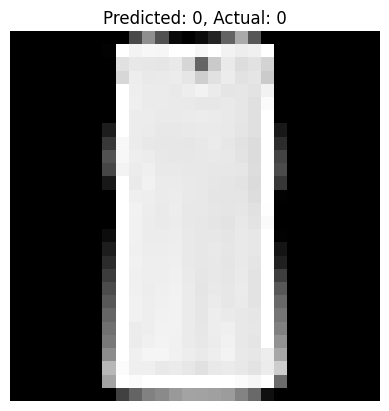


Running Experiment 2 with Layers: [64, 32], Optimizer: Adam, Epochs: 12
Epoch 1, Batch 100, Loss: 1.0609213042259216
Epoch 1, Batch 200, Loss: 0.5961478164792061
Epoch 1, Batch 300, Loss: 0.5530214482545852
Epoch 1, Batch 400, Loss: 0.5001158872246743
Epoch 1, Batch 500, Loss: 0.48549593687057496
Epoch 1, Batch 600, Loss: 0.46827691674232486
Epoch 1, Batch 700, Loss: 0.4799286454916
Epoch 1, Batch 800, Loss: 0.4600756412744522
Epoch 1, Batch 900, Loss: 0.41556833282113076
Epoch 2, Batch 100, Loss: 0.397728680819273
Epoch 2, Batch 200, Loss: 0.4148906120657921
Epoch 2, Batch 300, Loss: 0.42307478353381156
Epoch 2, Batch 400, Loss: 0.41464737012982367
Epoch 2, Batch 500, Loss: 0.39668250948190686
Epoch 2, Batch 600, Loss: 0.37626966685056684
Epoch 2, Batch 700, Loss: 0.3860833095014095
Epoch 2, Batch 800, Loss: 0.39260497480630874
Epoch 2, Batch 900, Loss: 0.3722805188596249
Epoch 3, Batch 100, Loss: 0.35587690979242326
Epoch 3, Batch 200, Loss: 0.36883149862289427
Epoch 3, Batch 300, L

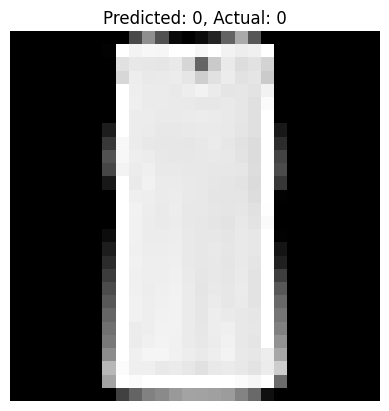


Running Experiment 3 with Layers: [128, 64], Optimizer: RMSprop, Epochs: 15
Epoch 1, Batch 100, Loss: 0.8146058174967766
Epoch 1, Batch 200, Loss: 0.5710436934232712
Epoch 1, Batch 300, Loss: 0.5247427901625633
Epoch 1, Batch 400, Loss: 0.49577355533838274
Epoch 1, Batch 500, Loss: 0.4667933928966522
Epoch 1, Batch 600, Loss: 0.46586905777454374
Epoch 1, Batch 700, Loss: 0.46323002338409425
Epoch 1, Batch 800, Loss: 0.4672053135931492
Epoch 1, Batch 900, Loss: 0.43211833700537683
Epoch 2, Batch 100, Loss: 0.41255209401249887
Epoch 2, Batch 200, Loss: 0.40830876961350443
Epoch 2, Batch 300, Loss: 0.41285469934344293
Epoch 2, Batch 400, Loss: 0.39059567466378214
Epoch 2, Batch 500, Loss: 0.39662577465176585
Epoch 2, Batch 600, Loss: 0.37612966418266297
Epoch 2, Batch 700, Loss: 0.3903117197751999
Epoch 2, Batch 800, Loss: 0.3724896837770939
Epoch 2, Batch 900, Loss: 0.3718596674501896
Epoch 3, Batch 100, Loss: 0.3620816794037819
Epoch 3, Batch 200, Loss: 0.35964983850717547
Epoch 3, Bat

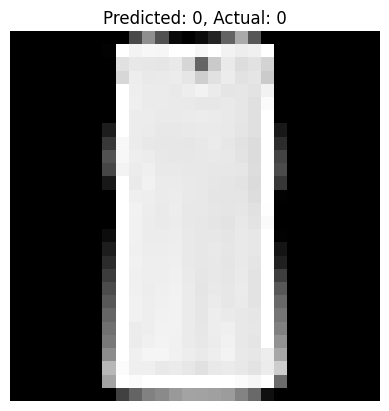


Running Experiment 4 with Layers: [64, 32, 16], Optimizer: SGD, Epochs: 50
Epoch 1, Batch 100, Loss: 2.3011305809020994
Epoch 1, Batch 200, Loss: 2.2928055143356323
Epoch 1, Batch 300, Loss: 2.2811441469192504
Epoch 1, Batch 400, Loss: 2.2711309719085695
Epoch 1, Batch 500, Loss: 2.255911314487457
Epoch 1, Batch 600, Loss: 2.2357252192497254
Epoch 1, Batch 700, Loss: 2.22201523065567
Epoch 1, Batch 800, Loss: 2.1948078989982607
Epoch 1, Batch 900, Loss: 2.170070505142212
Epoch 2, Batch 100, Loss: 2.1196221995353697
Epoch 2, Batch 200, Loss: 2.076145327091217
Epoch 2, Batch 300, Loss: 2.0307048630714415
Epoch 2, Batch 400, Loss: 1.981085761785507
Epoch 2, Batch 500, Loss: 1.9002364408969878
Epoch 2, Batch 600, Loss: 1.8340595948696137
Epoch 2, Batch 700, Loss: 1.7737768471240998
Epoch 2, Batch 800, Loss: 1.6915375125408172
Epoch 2, Batch 900, Loss: 1.6281771504878997
Epoch 3, Batch 100, Loss: 1.5257256138324737
Epoch 3, Batch 200, Loss: 1.4664076626300813
Epoch 3, Batch 300, Loss: 1.40

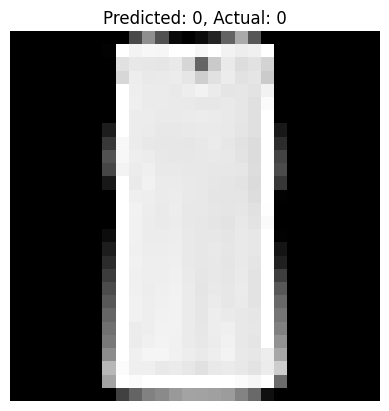


Running Experiment 5 with Layers: [128, 64, 32], Optimizer: Adam, Epochs: 12
Epoch 1, Batch 100, Loss: 1.7873651635646821
Epoch 1, Batch 200, Loss: 0.8988895457983017
Epoch 1, Batch 300, Loss: 0.7037921351194382
Epoch 1, Batch 400, Loss: 0.6237327525019646
Epoch 1, Batch 500, Loss: 0.5934664982557297
Epoch 1, Batch 600, Loss: 0.5654948011040688
Epoch 1, Batch 700, Loss: 0.5295830279588699
Epoch 1, Batch 800, Loss: 0.541969573199749
Epoch 1, Batch 900, Loss: 0.5174263453483582
Epoch 2, Batch 100, Loss: 0.5055704167485238
Epoch 2, Batch 200, Loss: 0.5008249169588089
Epoch 2, Batch 300, Loss: 0.45740105092525485
Epoch 2, Batch 400, Loss: 0.4606763339042664
Epoch 2, Batch 500, Loss: 0.451311851143837
Epoch 2, Batch 600, Loss: 0.4635904711484909
Epoch 2, Batch 700, Loss: 0.4348525394499302
Epoch 2, Batch 800, Loss: 0.44697492629289626
Epoch 2, Batch 900, Loss: 0.4297680951654911
Epoch 3, Batch 100, Loss: 0.43611050069332125
Epoch 3, Batch 200, Loss: 0.4357063554227352
Epoch 3, Batch 300, L

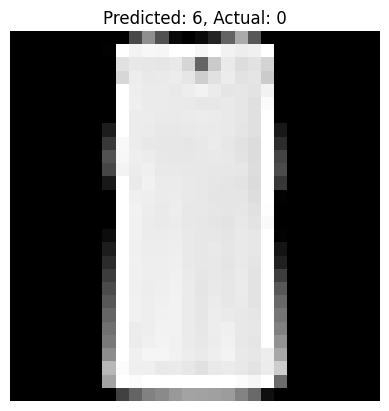


Running Experiment 6 with Layers: [256, 128], Optimizer: RMSprop, Epochs: 20
Epoch 1, Batch 100, Loss: 1.0314131379127502
Epoch 1, Batch 200, Loss: 0.6688187026977539
Epoch 1, Batch 300, Loss: 0.6049485358595849
Epoch 1, Batch 400, Loss: 0.5666793632507324
Epoch 1, Batch 500, Loss: 0.5521797022223472
Epoch 1, Batch 600, Loss: 0.5269488480687141
Epoch 1, Batch 700, Loss: 0.5244329804182053
Epoch 1, Batch 800, Loss: 0.5094291120767593
Epoch 1, Batch 900, Loss: 0.48505938798189163
Epoch 2, Batch 100, Loss: 0.48544331938028334
Epoch 2, Batch 200, Loss: 0.45561184450984
Epoch 2, Batch 300, Loss: 0.4630838158726692
Epoch 2, Batch 400, Loss: 0.46404615581035613
Epoch 2, Batch 500, Loss: 0.4496382100880146
Epoch 2, Batch 600, Loss: 0.4478179958462715
Epoch 2, Batch 700, Loss: 0.4178519839048386
Epoch 2, Batch 800, Loss: 0.42103277951478957
Epoch 2, Batch 900, Loss: 0.44295530587434767
Epoch 3, Batch 100, Loss: 0.4141875982284546
Epoch 3, Batch 200, Loss: 0.40033965662121773
Epoch 3, Batch 300

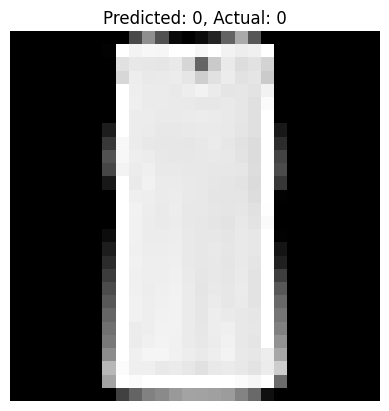


Running Experiment 7 with Layers: [32, 32], Optimizer: SGD, Epochs: 20
Epoch 1, Batch 100, Loss: 2.141067637205124
Epoch 1, Batch 200, Loss: 1.7237845194339751
Epoch 1, Batch 300, Loss: 1.2887380933761596
Epoch 1, Batch 400, Loss: 0.9942687457799911
Epoch 1, Batch 500, Loss: 0.8354322987794877
Epoch 1, Batch 600, Loss: 0.7413203519582748
Epoch 1, Batch 700, Loss: 0.6997922766208649
Epoch 1, Batch 800, Loss: 0.6598757016658783
Epoch 1, Batch 900, Loss: 0.6416000431776047
Epoch 2, Batch 100, Loss: 0.6117084658145905
Epoch 2, Batch 200, Loss: 0.600378836095333
Epoch 2, Batch 300, Loss: 0.579181809425354
Epoch 2, Batch 400, Loss: 0.5707929623126984
Epoch 2, Batch 500, Loss: 0.5766507560014724
Epoch 2, Batch 600, Loss: 0.5424055656790734
Epoch 2, Batch 700, Loss: 0.5464532488584518
Epoch 2, Batch 800, Loss: 0.5381777119636536
Epoch 2, Batch 900, Loss: 0.5169191840291023
Epoch 3, Batch 100, Loss: 0.5133906126022338
Epoch 3, Batch 200, Loss: 0.510254611670971
Epoch 3, Batch 300, Loss: 0.5015

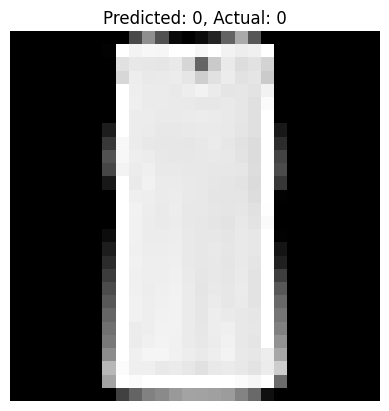


Running Experiment 8 with Layers: [64, 64], Optimizer: Adam, Epochs: 10
Epoch 1, Batch 100, Loss: 0.9879655784368515
Epoch 1, Batch 200, Loss: 0.5716661232709884
Epoch 1, Batch 300, Loss: 0.5167956274747848
Epoch 1, Batch 400, Loss: 0.4777178482711315
Epoch 1, Batch 500, Loss: 0.4824798783659935
Epoch 1, Batch 600, Loss: 0.47928667947649956
Epoch 1, Batch 700, Loss: 0.4436151067912579
Epoch 1, Batch 800, Loss: 0.45035374686121943
Epoch 1, Batch 900, Loss: 0.41683694228529933
Epoch 2, Batch 100, Loss: 0.40224932730197904
Epoch 2, Batch 200, Loss: 0.3988724300265312
Epoch 2, Batch 300, Loss: 0.4109270168840885
Epoch 2, Batch 400, Loss: 0.3949908296763897
Epoch 2, Batch 500, Loss: 0.40209521368145945
Epoch 2, Batch 600, Loss: 0.37810478612780574
Epoch 2, Batch 700, Loss: 0.399869264960289
Epoch 2, Batch 800, Loss: 0.3665331211686134
Epoch 2, Batch 900, Loss: 0.3854617948830128
Epoch 3, Batch 100, Loss: 0.34392881773412226
Epoch 3, Batch 200, Loss: 0.3699045918881893
Epoch 3, Batch 300, L

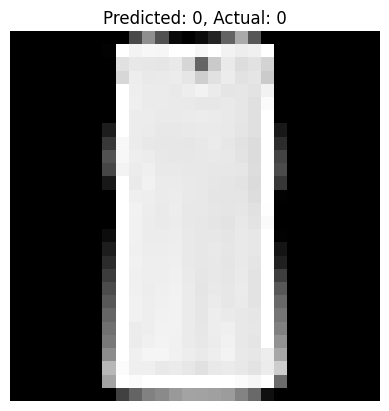


Running Experiment 9 with Layers: [128, 128], Optimizer: RMSprop, Epochs: 12
Epoch 1, Batch 100, Loss: 0.8190588423609734
Epoch 1, Batch 200, Loss: 0.5784981417655944
Epoch 1, Batch 300, Loss: 0.5140994945168496
Epoch 1, Batch 400, Loss: 0.49895594209432603
Epoch 1, Batch 500, Loss: 0.4762098616361618
Epoch 1, Batch 600, Loss: 0.44810232490301133
Epoch 1, Batch 700, Loss: 0.4382094544172287
Epoch 1, Batch 800, Loss: 0.4296928822994232
Epoch 1, Batch 900, Loss: 0.4402213132381439
Epoch 2, Batch 100, Loss: 0.40785567730665206
Epoch 2, Batch 200, Loss: 0.386960097849369
Epoch 2, Batch 300, Loss: 0.39727766618132593
Epoch 2, Batch 400, Loss: 0.39801654204726217
Epoch 2, Batch 500, Loss: 0.3582235497236252
Epoch 2, Batch 600, Loss: 0.38636909767985345
Epoch 2, Batch 700, Loss: 0.3761661027371883
Epoch 2, Batch 800, Loss: 0.3760911013185978
Epoch 2, Batch 900, Loss: 0.369529150724411
Epoch 3, Batch 100, Loss: 0.3515570253878832
Epoch 3, Batch 200, Loss: 0.35584872633218767
Epoch 3, Batch 30

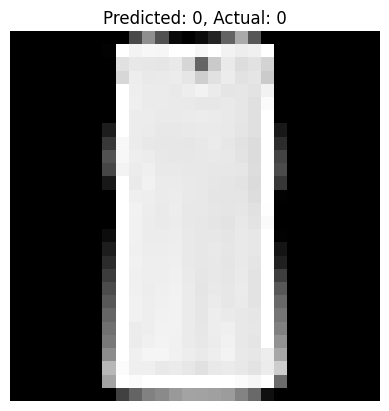


Running Experiment 10 with Layers: [256, 128, 64], Optimizer: SGD, Epochs: 20
Epoch 1, Batch 100, Loss: 2.2924834656715394
Epoch 1, Batch 200, Loss: 2.2621734666824342
Epoch 1, Batch 300, Loss: 2.21781569480896
Epoch 1, Batch 400, Loss: 2.1336925649642944
Epoch 1, Batch 500, Loss: 1.9716295397281647
Epoch 1, Batch 600, Loss: 1.7743715512752534
Epoch 1, Batch 700, Loss: 1.5909706127643586
Epoch 1, Batch 800, Loss: 1.400858337879181
Epoch 1, Batch 900, Loss: 1.2328164160251618
Epoch 2, Batch 100, Loss: 1.066710839867592
Epoch 2, Batch 200, Loss: 0.9751393675804139
Epoch 2, Batch 300, Loss: 0.9238379245996475
Epoch 2, Batch 400, Loss: 0.8666510474681854
Epoch 2, Batch 500, Loss: 0.8153952217102051
Epoch 2, Batch 600, Loss: 0.7845846378803253
Epoch 2, Batch 700, Loss: 0.7791549867391586
Epoch 2, Batch 800, Loss: 0.7449247515201569
Epoch 2, Batch 900, Loss: 0.7228321519494056
Epoch 3, Batch 100, Loss: 0.688955597281456
Epoch 3, Batch 200, Loss: 0.7097031927108765
Epoch 3, Batch 300, Loss: 

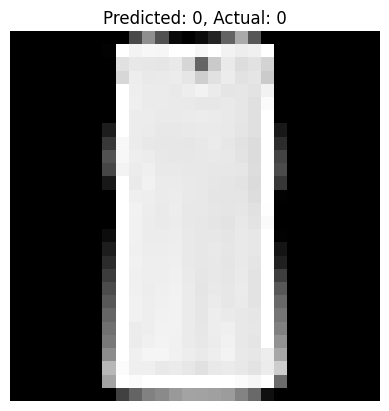


Running Experiment 11 with Layers: [512, 256], Optimizer: Adam, Epochs: 18
Epoch 1, Batch 100, Loss: 1.3325576251745224
Epoch 1, Batch 200, Loss: 0.6940574261546135
Epoch 1, Batch 300, Loss: 0.5871452102065087
Epoch 1, Batch 400, Loss: 0.5350811129808426
Epoch 1, Batch 500, Loss: 0.5344045463204384
Epoch 1, Batch 600, Loss: 0.4911941531300545
Epoch 1, Batch 700, Loss: 0.4876341784000397
Epoch 1, Batch 800, Loss: 0.48521153479814527
Epoch 1, Batch 900, Loss: 0.4375695744156837
Epoch 2, Batch 100, Loss: 0.4224544721841812
Epoch 2, Batch 200, Loss: 0.43225007072091104
Epoch 2, Batch 300, Loss: 0.4400905700027943
Epoch 2, Batch 400, Loss: 0.41134530663490293
Epoch 2, Batch 500, Loss: 0.4100109440088272
Epoch 2, Batch 600, Loss: 0.40195743545889856
Epoch 2, Batch 700, Loss: 0.42606434270739557
Epoch 2, Batch 800, Loss: 0.3995965632796288
Epoch 2, Batch 900, Loss: 0.394359330534935
Epoch 3, Batch 100, Loss: 0.3817953984439373
Epoch 3, Batch 200, Loss: 0.3876605536043644
Epoch 3, Batch 300, 

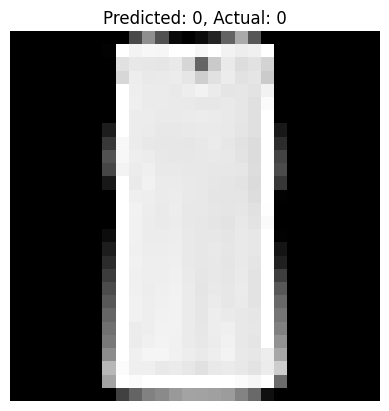


Running Experiment 12 with Layers: [32, 16, 8], Optimizer: RMSprop, Epochs: 20
Epoch 1, Batch 100, Loss: 1.0554686215519906
Epoch 1, Batch 200, Loss: 0.6725382068753243
Epoch 1, Batch 300, Loss: 0.6218535894155502
Epoch 1, Batch 400, Loss: 0.573662072122097
Epoch 1, Batch 500, Loss: 0.5436493514478207
Epoch 1, Batch 600, Loss: 0.4971629667282105
Epoch 1, Batch 700, Loss: 0.4977846044301987
Epoch 1, Batch 800, Loss: 0.4984250055253506
Epoch 1, Batch 900, Loss: 0.469078902900219
Epoch 2, Batch 100, Loss: 0.4545327532291412
Epoch 2, Batch 200, Loss: 0.45377665489912034
Epoch 2, Batch 300, Loss: 0.4290043057501316
Epoch 2, Batch 400, Loss: 0.43246031016111375
Epoch 2, Batch 500, Loss: 0.4203499735891819
Epoch 2, Batch 600, Loss: 0.44647900223731996
Epoch 2, Batch 700, Loss: 0.4335248742997646
Epoch 2, Batch 800, Loss: 0.42243884220719335
Epoch 2, Batch 900, Loss: 0.42132934466004374
Epoch 3, Batch 100, Loss: 0.4175140500068665
Epoch 3, Batch 200, Loss: 0.3816632269322872
Epoch 3, Batch 30

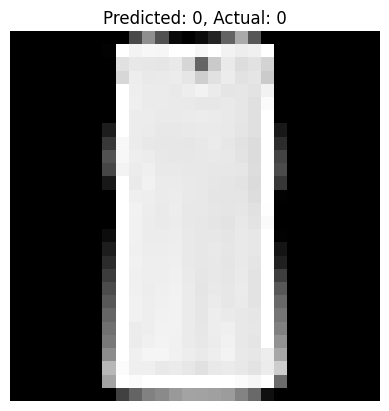


Running Experiment 13 with Layers: [64, 32, 16], Optimizer: SGD, Epochs: 50
Epoch 1, Batch 100, Loss: 2.3115538954734802
Epoch 1, Batch 200, Loss: 2.2957972645759583
Epoch 1, Batch 300, Loss: 2.2804498529434203
Epoch 1, Batch 400, Loss: 2.2645642375946045
Epoch 1, Batch 500, Loss: 2.2417254185676576
Epoch 1, Batch 600, Loss: 2.213271219730377
Epoch 1, Batch 700, Loss: 2.1864312362670897
Epoch 1, Batch 800, Loss: 2.1412910795211793
Epoch 1, Batch 900, Loss: 2.080161899328232
Epoch 2, Batch 100, Loss: 1.9943321394920348
Epoch 2, Batch 200, Loss: 1.934820603132248
Epoch 2, Batch 300, Loss: 1.8634469747543334
Epoch 2, Batch 400, Loss: 1.7899752867221832
Epoch 2, Batch 500, Loss: 1.7365421259403229
Epoch 2, Batch 600, Loss: 1.6496791136264801
Epoch 2, Batch 700, Loss: 1.5647271847724915
Epoch 2, Batch 800, Loss: 1.4455930531024932
Epoch 2, Batch 900, Loss: 1.3407980501651764
Epoch 3, Batch 100, Loss: 1.2102191412448884
Epoch 3, Batch 200, Loss: 1.1458889317512513
Epoch 3, Batch 300, Loss: 

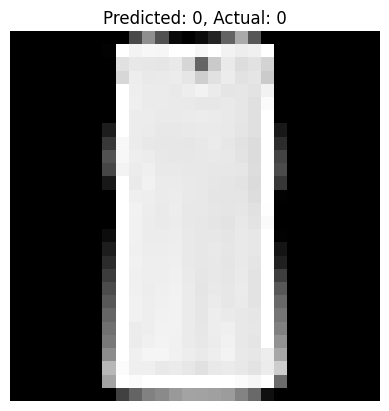


Running Experiment 14 with Layers: [128, 64, 32], Optimizer: Adam, Epochs: 15
Epoch 1, Batch 100, Loss: 1.0469370606541633
Epoch 1, Batch 200, Loss: 0.5968055346608162
Epoch 1, Batch 300, Loss: 0.5415314885973931
Epoch 1, Batch 400, Loss: 0.5080911123752594
Epoch 1, Batch 500, Loss: 0.5022968536615372
Epoch 1, Batch 600, Loss: 0.4636560866236687
Epoch 1, Batch 700, Loss: 0.4631780177354813
Epoch 1, Batch 800, Loss: 0.45121584221720695
Epoch 1, Batch 900, Loss: 0.4234832811355591
Epoch 2, Batch 100, Loss: 0.4237059170007706
Epoch 2, Batch 200, Loss: 0.4113895861804485
Epoch 2, Batch 300, Loss: 0.39943642288446424
Epoch 2, Batch 400, Loss: 0.38516442283988
Epoch 2, Batch 500, Loss: 0.3869210863113403
Epoch 2, Batch 600, Loss: 0.3770969119668007
Epoch 2, Batch 700, Loss: 0.369330198764801
Epoch 2, Batch 800, Loss: 0.3909338326752186
Epoch 2, Batch 900, Loss: 0.3685860860347748
Epoch 3, Batch 100, Loss: 0.36587283536791804
Epoch 3, Batch 200, Loss: 0.37387513056397437
Epoch 3, Batch 300, 

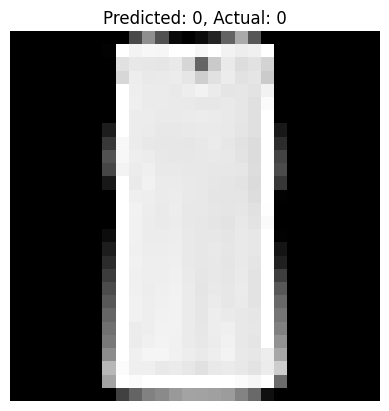


Running Experiment 15 with Layers: [256, 128, 64], Optimizer: RMSprop, Epochs: 20
Epoch 1, Batch 100, Loss: 1.0074256509542465
Epoch 1, Batch 200, Loss: 0.655043195784092
Epoch 1, Batch 300, Loss: 0.6032423907518387
Epoch 1, Batch 400, Loss: 0.5608934475481511
Epoch 1, Batch 500, Loss: 0.5150182081758976
Epoch 1, Batch 600, Loss: 0.4997982060909271
Epoch 1, Batch 700, Loss: 0.4823784413933754
Epoch 1, Batch 800, Loss: 0.47176040440797806
Epoch 1, Batch 900, Loss: 0.48418017357587817
Epoch 2, Batch 100, Loss: 0.43669426247477533
Epoch 2, Batch 200, Loss: 0.42554163947701457
Epoch 2, Batch 300, Loss: 0.4453815813362598
Epoch 2, Batch 400, Loss: 0.43078565374016764
Epoch 2, Batch 500, Loss: 0.44358569487929345
Epoch 2, Batch 600, Loss: 0.42692975714802744
Epoch 2, Batch 700, Loss: 0.40991273015737534
Epoch 2, Batch 800, Loss: 0.41841903418302534
Epoch 2, Batch 900, Loss: 0.4116519495844841
Epoch 3, Batch 100, Loss: 0.4028821070492268
Epoch 3, Batch 200, Loss: 0.40430415466427805
Epoch 3,

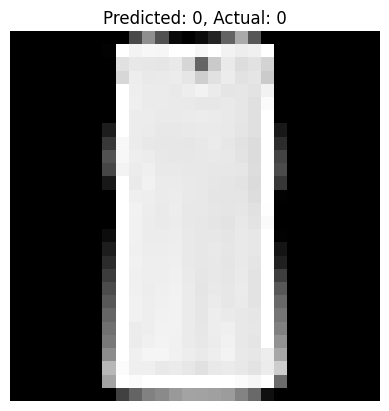

In [201]:
# Run each experiment and record the results
for idx, config in enumerate(experiments):
    print(f"\nRunning Experiment {idx + 1} with Layers: {config['layers']}, Optimizer: {config['optimizer']}, Epochs: {config['epochs']}")

    # Initialize the model
    model = MLP(config['layers'])

    # Initialize the optimizer
    if config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    accuracy = train_and_evaluate(model, optimizer, criterion, num_epochs=config['epochs'])

    # Get hidden layer sizes as a string for recording
    hidden_layer_sizes = ', '.join([str(layer) for layer in config['layers']])

    # Record the results, including hidden layer sizes and other requested details
    results_df = pd.concat([results_df, pd.DataFrame({
        'Experiment': [f'Experiment {idx + 1}'],
        'Layers': [len(config['layers'])],
        'Hidden Layer Sizes': [hidden_layer_sizes],
        'Training Data Division': ['60,000 Training / 10,000 Testing'],
        'Batch Size': [batch_size],
        'Learning Rate': [config['lr']],
        'Optimizer': [config['optimizer']],
        'Accuracy': [accuracy * 100]
    })], ignore_index=True)
    # Display a sample image with its predicted and actual labels
    image_index = 27
    test_image, test_label = test_dataset[image_index]

    with torch.no_grad():
        model.eval()
        output = model(test_image.unsqueeze(0))  # Add batch dimension for the input
        _, predicted_label = torch.max(output, 1)

    test_image_numpy = test_image.squeeze().numpy()

    plt.imshow(test_image_numpy, cmap='gray')
    plt.title(f'Predicted: {labels_map[predicted_label.item()]}, Actual: {labels_map[test_label]}')
    plt.axis('off')
    plt.show()

In [202]:
# Display the experiment results table
print("\nExperiment Results Table:")
print(results_df)

# Save the results as an Excel file
results_df.to_excel('results2.xlsx', index=False)


Experiment Results Table:
       Experiment Layers Hidden Layer Sizes Batch Size  Learning Rate  \
0    Experiment 1      2             64, 32         64         0.0030   
1    Experiment 2      2             64, 32         64         0.0010   
2    Experiment 3      2            128, 64         64         0.0005   
3    Experiment 4      3         64, 32, 16         64         0.0020   
4    Experiment 5      3        128, 64, 32         64         0.0002   
5    Experiment 6      2           256, 128         64         0.0001   
6    Experiment 7      2             32, 32         64         0.0100   
7    Experiment 8      2             64, 64         64         0.0010   
8    Experiment 9      2           128, 128         64         0.0005   
9   Experiment 10      3       256, 128, 64         64         0.0050   
10  Experiment 11      2           512, 256         64         0.0001   
11  Experiment 12      3          32, 16, 8         64         0.0020   
12  Experiment 13      3

# Task - 3

Under the second section of the Notebook you’ll see a Keras implementation of a CNN. Use that
configuration as a template to start adjusting. Follow the elements below to drive for the best
accuracy you can achieve!

(Industry standard is 96.7% but our tests topped out near 90% -- see if you can beat it?)

## Number and Type of Layers
The framework for the model provided is intentionally a bit suspect. Add layers (conv2d,pool,dropout. etc.) where appropriate.

➢ one element or layer at a time (please try at least 10 configurations – this does not mean 10 layer, but please employ some different orders to the layers at your disposal)
## Kernel “Depth” 
Set the values for the number of kernels present in the conv2d layers, pool sizes, and sequences

Setting larger values will take longer to train, but may improve performance.

➢ Construct at least 5 variations on your network parameters
## Batch size 
Adjust the number of samples used to train the network per update.

➢ Select at least 5 values appropriate to the task and available memory
## Optimizer 
Using the Keras reference, select another optimization function and adjust the relevant parameters

➢ Try at least 2 different methods and 5 different parameter settings for each (lr,decay,reg)

➢ (optional) Implement some form of iterative hyperparameter optimization

In [316]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [317]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [318]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [319]:
# Define experiment configurations
experiments = [
    {'layers': [('conv', 32), ('pool',), ('conv', 64), ('pool',), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.004, 'batch_size': 32, 'epochs': 40},
    {'layers': [('conv', 64), ('pool',), ('conv', 128), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 64, 'epochs': 15},
    {'layers': [('conv', 32), ('pool',), ('conv', 64), ('conv', 128), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.005, 'batch_size': 48, 'epochs': 30},
    {'layers': [('conv', 64), ('conv', 64), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'Adam', 'lr': 0.0003, 'batch_size': 32, 'epochs': 4},
    {'layers': [('conv', 128), ('pool',), ('conv', 128), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.02, 'batch_size': 64, 'epochs': 25},
    {'layers': [('conv', 32), ('conv', 64), ('conv', 128), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'Adam', 'lr': 0.002, 'batch_size': 32, 'epochs': 5},
    {'layers': [('conv', 64), ('pool',), ('conv', 64), ('conv', 128), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.003, 'batch_size': 32, 'epochs': 35},
    {'layers': [('conv', 128), ('conv', 64), ('pool',), ('conv', 64), ('flatten',), ('dense', 128)], 'optimizer': 'Adam', 'lr': 0.0002, 'batch_size': 48, 'epochs': 9},
    {'layers': [('conv', 64), ('pool',), ('conv', 128), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'SGD', 'lr': 0.005, 'batch_size': 32, 'epochs': 25},
    {'layers': [('conv', 32), ('conv', 32), ('conv', 64), ('flatten',), ('dense', 128)], 'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 64, 'epochs': 5},
    {'layers': [('conv', 128), ('conv', 64), ('conv', 32), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'SGD', 'lr': 0.004, 'batch_size': 48, 'epochs': 30},
    {'layers': [('conv', 64), ('conv', 128), ('conv', 64), ('flatten',), ('dense', 256)], 'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'epochs': 3},
    {'layers': [('conv', 32), ('pool',), ('conv', 32), ('conv', 64), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.03, 'batch_size': 64, 'epochs': 25},
    {'layers': [('conv', 64), ('conv', 128), ('conv', 128), ('pool',), ('flatten',), ('dense', 256)], 'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'epochs': 5},
    {'layers': [('conv', 128), ('pool',), ('conv', 64), ('conv', 64), ('flatten',), ('dense', 128)], 'optimizer': 'SGD', 'lr': 0.005, 'batch_size': 48, 'epochs': 20},
    {'layers': [('conv', 32), ('conv', 64), ('conv', 32), ('pool',), ('flatten',), ('dense', 128)], 'optimizer': 'Adam', 'lr': 0.0002, 'batch_size': 32, 'epochs': 6},
    {'layers': [('conv', 128), ('pool',), ('conv', 128), ('conv', 64), ('flatten',), ('dense', 256)], 'optimizer': 'SGD', 'lr': 0.003, 'batch_size': 64, 'epochs': 25},
    {'layers': [('conv', 64), ('conv', 32), ('pool',), ('conv', 128), ('flatten',), ('dense', 128)], 'optimizer': 'Adam', 'lr': 0.002, 'batch_size': 48, 'epochs': 5},
    {'layers': [('conv', 64), ('conv', 64), ('pool',), ('conv', 64), ('flatten',), ('dense', 256)], 'optimizer': 'SGD', 'lr': 0.004, 'batch_size': 32, 'epochs': 20},
    {'layers': [('conv', 64), ('pool',), ('conv', 128), ('flatten',), ('dense', 128)], 'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 64, 'epochs': 4}
]


In [320]:
# Prepare a DataFrame to store the results
results_df = pd.DataFrame(columns=['Experiment', 'Layers', 'Kernel Depth', 'Training Data Division', 'Batch Size', 'Learning Rate', 'Optimizer', 'Accuracy'])

In [321]:
# Function to build the CNN model based on the layer configuration
def build_model(layer_config):
    model = Sequential()
    for layer_type, *layer_params in layer_config:
        if layer_type == 'conv':
            model.add(Conv2D(layer_params[0], (3, 3), activation='relu', input_shape=(28, 28, 1) if len(model.layers) == 0 else None))
        elif layer_type == 'pool':
            model.add(MaxPooling2D(pool_size=(2, 2)))
        elif layer_type == 'flatten':
            model.add(Flatten())
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='sigmoid'))
        elif layer_type == 'dense':
            model.add(Dense(layer_params[0], activation='relu'))
    model.add(Dense(10, activation='softmax')) 
    return model

Running Experiment 1
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/40


/Users/nanxuan/miniconda3/envs/dp5567/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1736 - loss: 2.2920 - val_accuracy: 0.5041 - val_loss: 1.5842
Epoch 2/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5879 - loss: 1.2454 - val_accuracy: 0.6882 - val_loss: 0.8870
Epoch 3/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6923 - loss: 0.8397 - val_accuracy: 0.7040 - val_loss: 0.7509
Epoch 4/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7265 - loss: 0.7364 - val_accuracy: 0.7452 - val_loss: 0.6833
Epoch 5/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7437 - loss: 0.6814 - val_accuracy: 0.7540 - val_loss: 0.6468
Epoch 6/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7578 - loss: 0.6383 - val_accuracy: 0.7731 - val_loss: 0.6050
Epoch 7/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7691 - loss: 0.6048 - val_accuracy: 0.7818 - val_loss: 0.5795
Epoch 8/40
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7812 - loss: 0.5768 - val

/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_7868/1449936004.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


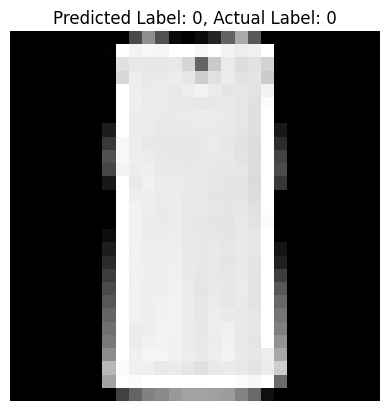

Running Experiment 2
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6993 - loss: 0.8091 - val_accuracy: 0.8584 - val_loss: 0.3931
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8735 - loss: 0.3427 - val_accuracy: 0.8848 - val_loss: 0.3199
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8947 - loss: 0.2848 - val_accuracy: 0.8974 - val_loss: 0.2771
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9095 - loss: 0.2428 - val_accuracy: 0.8949 - val_loss: 0.2882
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9179 - loss: 0.2198 - val_accuracy: 0.9057 - val_loss: 0.2637
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9322 - loss: 0.1836 - val_accuracy: 0.9079 - val_loss: 0.2526
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9397 - loss: 0.1674 - 

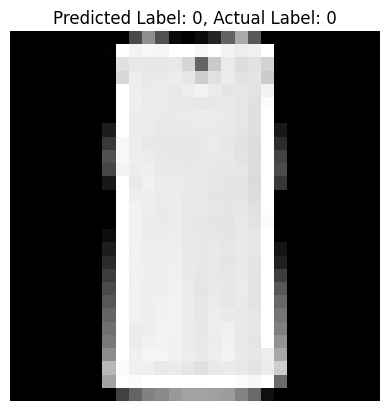

Running Experiment 3
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1963 - loss: 2.2747 - val_accuracy: 0.6133 - val_loss: 1.1853
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6488 - loss: 0.9999 - val_accuracy: 0.7038 - val_loss: 0.7697
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7113 - loss: 0.7604 - val_accuracy: 0.7380 - val_loss: 0.6847
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7412 - loss: 0.6860 - val_accuracy: 0.7508 - val_loss: 0.6592
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7519 - loss: 0.6442 - val_accuracy: 0.7709 - val_loss: 0.6191
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7684 - loss: 0.6050 - val_accuracy: 0.7847 - val_loss: 0.5672
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7794 - l

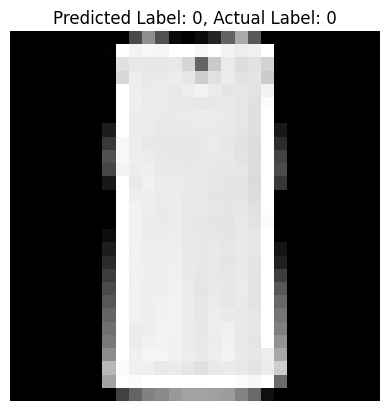

Running Experiment 4
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/4
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7384 - loss: 0.7347 - val_accuracy: 0.8733 - val_loss: 0.3491
Epoch 2/4
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8869 - loss: 0.3109 - val_accuracy: 0.9015 - val_loss: 0.2705
Epoch 3/4
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9107 - loss: 0.2450 - val_accuracy: 0.9092 - val_loss: 0.2491
Epoch 4/4
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.9242 - loss: 0.2038 - val_accuracy: 0.9087 - val_loss: 0.2568
Training complete, evaluating model...
Experiment 4 - Test Accuracy: 90.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


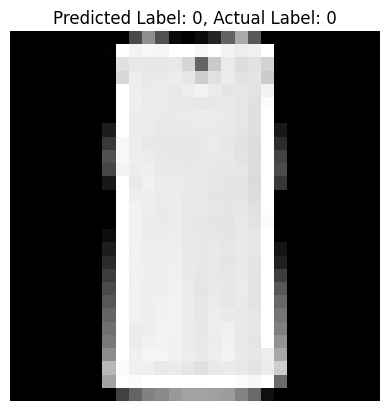

Running Experiment 5
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.3695 - loss: 1.7660 - val_accuracy: 0.7080 - val_loss: 0.7241
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7404 - loss: 0.6693 - val_accuracy: 0.7786 - val_loss: 0.5628
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7717 - loss: 0.5852 - val_accuracy: 0.8102 - val_loss: 0.5076
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7988 - loss: 0.5269 - val_accuracy: 0.8205 - val_loss: 0.4844
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8182 - loss: 0.4861 - val_accuracy: 0.8213 - val_loss: 0.4725
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8327 - loss: 0.4544 - val_accuracy: 0.8282 - val_loss: 0.4522
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8380 - loss: 0.4329 - 

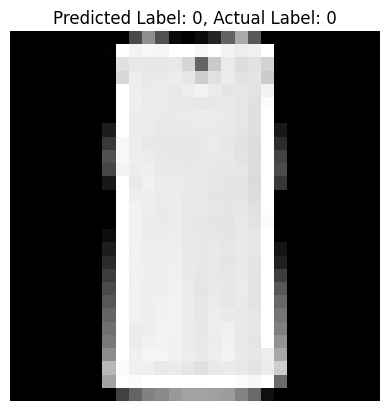

Running Experiment 6
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7660 - loss: 0.6247 - val_accuracy: 0.8866 - val_loss: 0.3166
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8929 - loss: 0.2932 - val_accuracy: 0.8957 - val_loss: 0.2900
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9179 - loss: 0.2311 - val_accuracy: 0.9107 - val_loss: 0.2545
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9287 - loss: 0.1945 - val_accuracy: 0.9195 - val_loss: 0.2411
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9427 - loss: 0.1595 - val_accuracy: 0.9218 - val_loss: 0.2359
Training complete, evaluating model...
Experiment 6 - Test Accuracy: 91.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


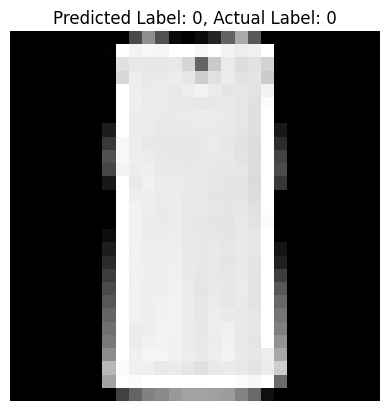

Running Experiment 7
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.1598 - loss: 2.2945 - val_accuracy: 0.5295 - val_loss: 1.5152
Epoch 2/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6073 - loss: 1.1740 - val_accuracy: 0.7103 - val_loss: 0.7890
Epoch 3/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7103 - loss: 0.7803 - val_accuracy: 0.7352 - val_loss: 0.7110
Epoch 4/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7333 - loss: 0.7065 - val_accuracy: 0.7260 - val_loss: 0.6634
Epoch 5/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7484 - loss: 0.6602 - val_accuracy: 0.7632 - val_loss: 0.6108
Epoch 6/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7660 - loss: 0.6136 - val_accuracy: 0.7801 - val_loss: 0.5874
Epoch 7/35
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7747 - l

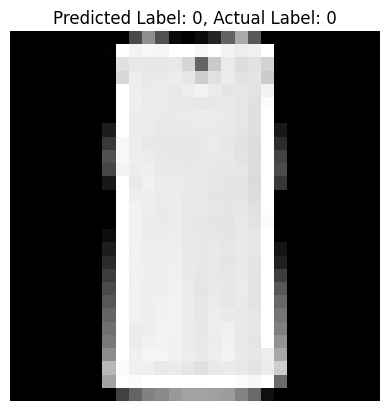

Running Experiment 8
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.6828 - loss: 0.9170 - val_accuracy: 0.8506 - val_loss: 0.4122
Epoch 2/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.8584 - loss: 0.3845 - val_accuracy: 0.8816 - val_loss: 0.3249
Epoch 3/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.8887 - loss: 0.3019 - val_accuracy: 0.8852 - val_loss: 0.3108
Epoch 4/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9017 - loss: 0.2667 - val_accuracy: 0.8999 - val_loss: 0.2855
Epoch 5/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9166 - loss: 0.2288 - val_accuracy: 0.9060 - val_loss: 0.2584
Epoch 6/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9279 - loss: 0.1968 - val_accuracy: 0.9131 - val_loss: 0.2438
Epoch 7/9
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9361 - loss: 0.

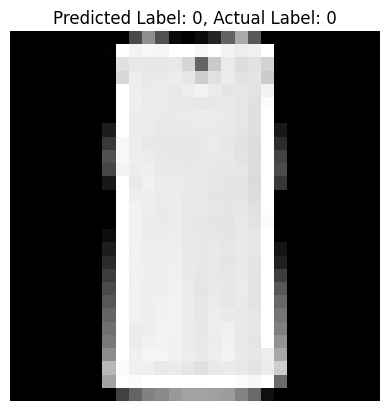

Running Experiment 9
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.1432 - loss: 2.2961 - val_accuracy: 0.4399 - val_loss: 1.8401
Epoch 2/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5463 - loss: 1.3655 - val_accuracy: 0.6702 - val_loss: 0.8821
Epoch 3/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6869 - loss: 0.8514 - val_accuracy: 0.7193 - val_loss: 0.7421
Epoch 4/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7235 - loss: 0.7314 - val_accuracy: 0.7458 - val_loss: 0.6847
Epoch 5/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7467 - loss: 0.6693 - val_accuracy: 0.7662 - val_loss: 0.6199
Epoch 6/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7634 - loss: 0.6195 - val_accuracy: 0.7807 - val_loss: 0.5787
Epoch 7/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7756 - loss: 0.

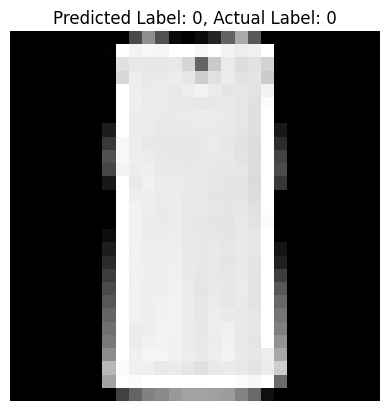

Running Experiment 10
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.7656 - loss: 0.6605 - val_accuracy: 0.8799 - val_loss: 0.3197
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9004 - loss: 0.2754 - val_accuracy: 0.9023 - val_loss: 0.2614
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9249 - loss: 0.2037 - val_accuracy: 0.9144 - val_loss: 0.2379
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9470 - loss: 0.1468 - val_accuracy: 0.9118 - val_loss: 0.2647
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9642 - loss: 0.1031 - val_accuracy: 0.9133 - val_loss: 0.2926
Training complete, evaluating model...
Experiment 10 - Test Accuracy: 90.74%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


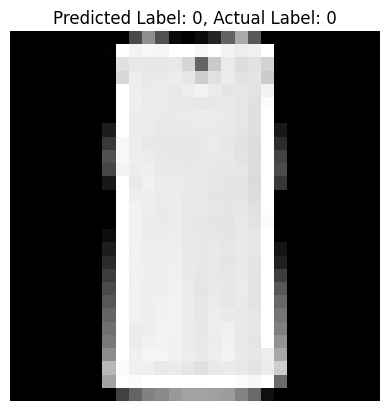

Running Experiment 11
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.1458 - loss: 2.2928 - val_accuracy: 0.5514 - val_loss: 1.5363
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.6502 - loss: 1.1146 - val_accuracy: 0.7527 - val_loss: 0.6868
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7552 - loss: 0.6710 - val_accuracy: 0.7742 - val_loss: 0.6059
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7745 - loss: 0.5994 - val_accuracy: 0.7799 - val_loss: 0.5818
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7924 - loss: 0.5514 - val_accuracy: 0.8029 - val_loss: 0.5272
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.8032 - loss: 0.5201 - val_accuracy: 0.7966 - val_loss: 0.5217
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.8136 - 

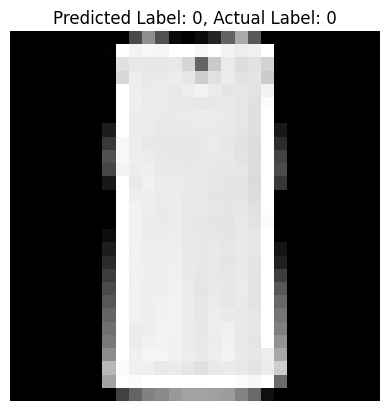

Running Experiment 12
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.7673 - loss: 0.6362 - val_accuracy: 0.8744 - val_loss: 0.3379
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.8966 - loss: 0.2814 - val_accuracy: 0.9002 - val_loss: 0.2750
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9251 - loss: 0.2058 - val_accuracy: 0.9128 - val_loss: 0.2501
Training complete, evaluating model...
Experiment 12 - Test Accuracy: 90.94%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


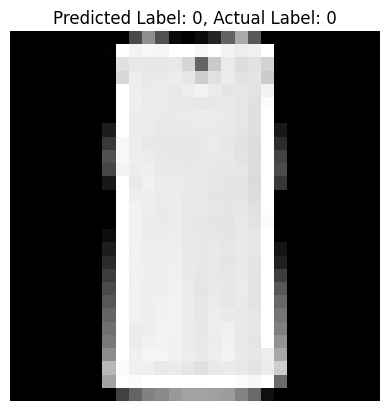

Running Experiment 13
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3979 - loss: 1.6315 - val_accuracy: 0.7237 - val_loss: 0.7013
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7435 - loss: 0.6643 - val_accuracy: 0.7983 - val_loss: 0.5445
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7952 - loss: 0.5345 - val_accuracy: 0.8167 - val_loss: 0.4961
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8275 - loss: 0.4648 - val_accuracy: 0.8350 - val_loss: 0.4505
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8460 - loss: 0.4190 - val_accuracy: 0.8585 - val_loss: 0.3947
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8571 - loss: 0.3881 - val_accuracy: 0.8638 - val_loss: 0.3720
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8688 - loss: 0.3550 - val_accur

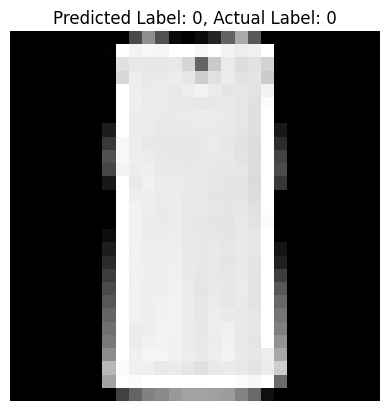

Running Experiment 14
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 62s 41ms/step - accuracy: 0.7517 - loss: 0.6855 - val_accuracy: 0.8763 - val_loss: 0.3283
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.9006 - loss: 0.2731 - val_accuracy: 0.9093 - val_loss: 0.2489
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.9216 - loss: 0.2153 - val_accuracy: 0.9111 - val_loss: 0.2375
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 62s 41ms/step - accuracy: 0.9399 - loss: 0.1648 - val_accuracy: 0.9208 - val_loss: 0.2263
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9543 - loss: 0.1259 - val_accuracy: 0.9177 - val_loss: 0.2516
Training complete, evaluating model...
Experiment 14 - Test Accuracy: 91.32%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


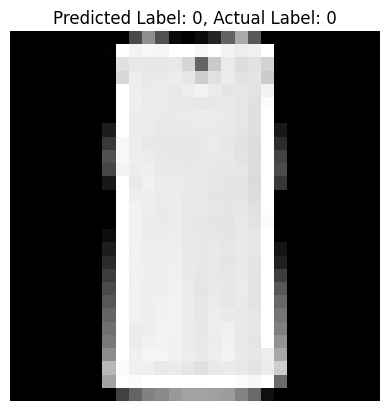

Running Experiment 15
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1829 - loss: 2.2489 - val_accuracy: 0.6265 - val_loss: 1.1507
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6546 - loss: 0.9830 - val_accuracy: 0.7071 - val_loss: 0.7641
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7153 - loss: 0.7513 - val_accuracy: 0.7463 - val_loss: 0.6865
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7397 - loss: 0.6766 - val_accuracy: 0.7092 - val_loss: 0.7098
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7566 - loss: 0.6310 - val_accuracy: 0.7655 - val_loss: 0.6002
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7761 - loss: 0.5938 - val_accuracy: 0.7830 - val_loss: 0.5670
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7839 - 

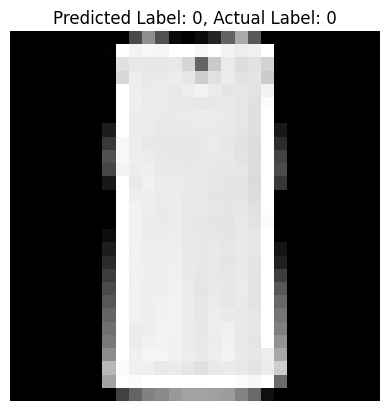

Running Experiment 16
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7057 - loss: 0.8341 - val_accuracy: 0.8578 - val_loss: 0.3953
Epoch 2/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8699 - loss: 0.3573 - val_accuracy: 0.8915 - val_loss: 0.3018
Epoch 3/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8955 - loss: 0.2861 - val_accuracy: 0.8978 - val_loss: 0.2849
Epoch 4/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9096 - loss: 0.2432 - val_accuracy: 0.9086 - val_loss: 0.2600
Epoch 5/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9215 - loss: 0.2124 - val_accuracy: 0.9093 - val_loss: 0.2498
Epoch 6/6
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9292 - loss: 0.1883 - val_accuracy: 0.9127 - val_loss: 0.2433
Training complete, evaluating model...
Experiment 16 - Test Accuracy: 91.06%
1/1 ━━

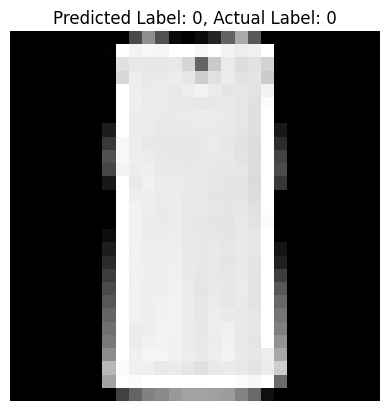

Running Experiment 17
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.1208 - loss: 2.3129 - val_accuracy: 0.2095 - val_loss: 2.2829
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.2953 - loss: 2.2500 - val_accuracy: 0.5342 - val_loss: 1.7603
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5680 - loss: 1.4704 - val_accuracy: 0.6515 - val_loss: 0.9904
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6736 - loss: 0.9461 - val_accuracy: 0.7089 - val_loss: 0.8174
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7077 - loss: 0.8042 - val_accuracy: 0.7284 - val_loss: 0.7407
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7207 - loss: 0.7479 - val_accuracy: 0.6894 - val_loss: 0.7853
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7358 - loss: 0.7047 -

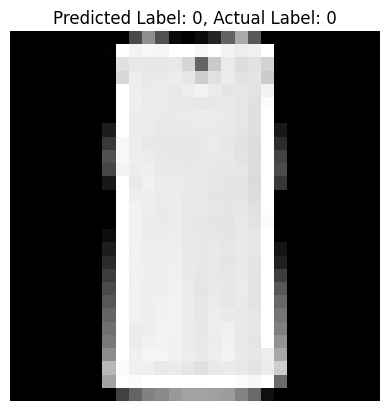

Running Experiment 18
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.7516 - loss: 0.6553 - val_accuracy: 0.8827 - val_loss: 0.3267
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8981 - loss: 0.2778 - val_accuracy: 0.8982 - val_loss: 0.2715
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9202 - loss: 0.2200 - val_accuracy: 0.9147 - val_loss: 0.2392
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9325 - loss: 0.1783 - val_accuracy: 0.9167 - val_loss: 0.2489
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9480 - loss: 0.1422 - val_accuracy: 0.9115 - val_loss: 0.2507
Training complete, evaluating model...
Experiment 18 - Test Accuracy: 91.09%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


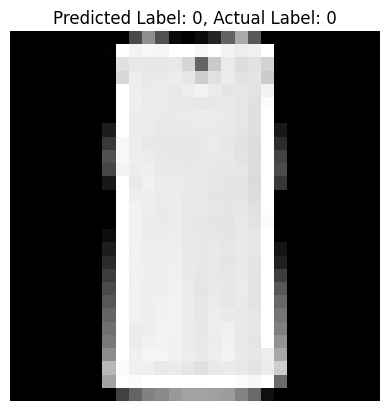

Running Experiment 19
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.1838 - loss: 2.2236 - val_accuracy: 0.6733 - val_loss: 0.9719
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.6958 - loss: 0.8647 - val_accuracy: 0.7538 - val_loss: 0.6713
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7485 - loss: 0.6672 - val_accuracy: 0.7456 - val_loss: 0.6262
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7683 - loss: 0.6048 - val_accuracy: 0.7775 - val_loss: 0.5720
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7859 - loss: 0.5593 - val_accuracy: 0.8087 - val_loss: 0.5193
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8012 - loss: 0.5258 - val_accuracy: 0.8118 - val_loss: 0.5047
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8126 - 

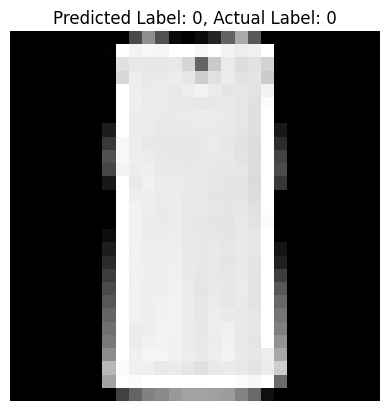

Running Experiment 20
Building and compiling the model...
Compiling model with optimizer and learning rate...
Starting training...
Epoch 1/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7323 - loss: 0.7620 - val_accuracy: 0.8669 - val_loss: 0.3597
Epoch 2/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8802 - loss: 0.3357 - val_accuracy: 0.8797 - val_loss: 0.3233
Epoch 3/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8982 - loss: 0.2811 - val_accuracy: 0.9021 - val_loss: 0.2804
Epoch 4/4
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9133 - loss: 0.2337 - val_accuracy: 0.9062 - val_loss: 0.2521
Training complete, evaluating model...
Experiment 20 - Test Accuracy: 90.13%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


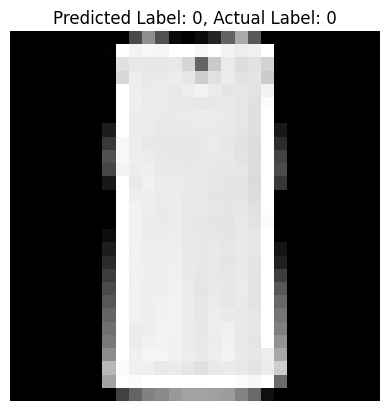

In [322]:
# Run experiments and save results
for idx, config in enumerate(experiments):
    print(f"Running Experiment {idx + 1}")
    
    print("Building and compiling the model...")
    model = build_model(config['layers'])

    print("Compiling model with optimizer and learning rate...")
    if config['optimizer'] == 'SGD':
        optimizer = SGD(learning_rate=config['lr'])
    elif config['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=config['lr'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print("Starting training...")
    history = model.fit(x_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], verbose=1, validation_split=0.2)

    print("Training complete, evaluating model...")
    
    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Experiment {idx + 1} - Test Accuracy: {accuracy * 100:.2f}%")
    
    # Record the layer structure as a string for output
    layer_structure = ', '.join([f"{layer_type}({params[0]})" if layer_type == 'conv' or layer_type == 'dense' else layer_type for layer_type, *params in config['layers']])
    kernel_depth = sum([params[0] for layer_type, *params in config['layers'] if layer_type == 'conv'])
    
    # Add results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Experiment': [f'Experiment {idx + 1}'],
        'Layers': [len(config['layers']) + 2],
        'Kernel Depth': [kernel_depth],
        'Training Data Division': ['60,000 Training / 10,000 Testing'],
        'Batch Size': [config['batch_size']],
        'Learning Rate': [config['lr']],
        'Optimizer': [config['optimizer']],
        'Accuracy': [accuracy * 100]
    })], ignore_index=True)
    # Display a sample prediction with image
    image_index = 27
    test_image = x_test[image_index]
    test_label = np.argmax(y_test[image_index])

    # Make predictions
    predicted_label = np.argmax(model.predict(np.expand_dims(test_image, axis=0)), axis=-1)

    # Plot the image with predictions
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
    plt.axis('off')
    plt.show()

In [323]:
# Display the experiment results table
print("\nExperiment Results Table:")
print(results_df)

# Save results to Excel
results_df.to_excel('results3.xlsx', index=False)


Experiment Results Table:
       Experiment Layers Kernel Depth            Training Data Division  \
0    Experiment 1      8           96  60,000 Training / 10,000 Testing   
1    Experiment 2      8          192  60,000 Training / 10,000 Testing   
2    Experiment 3      8          224  60,000 Training / 10,000 Testing   
3    Experiment 4      7          128  60,000 Training / 10,000 Testing   
4    Experiment 5      7          256  60,000 Training / 10,000 Testing   
5    Experiment 6      8          224  60,000 Training / 10,000 Testing   
6    Experiment 7      8          256  60,000 Training / 10,000 Testing   
7    Experiment 8      8          256  60,000 Training / 10,000 Testing   
8    Experiment 9      8          192  60,000 Training / 10,000 Testing   
9   Experiment 10      7          128  60,000 Training / 10,000 Testing   
10  Experiment 11      8          224  60,000 Training / 10,000 Testing   
11  Experiment 12      7          256  60,000 Training / 10,000 Testing  

# Task1 Graph

     Experiment  Layers Hidden Layer Sizes            Training Data Division  \
0  Experiment 1       2             32, 16  60,000 Training / 10,000 Testing   
1  Experiment 2       2             64, 32  60,000 Training / 10,000 Testing   
2  Experiment 3       2            128, 64  60,000 Training / 10,000 Testing   
3  Experiment 4       3         64, 32, 16  60,000 Training / 10,000 Testing   
4  Experiment 5       3        128, 64, 32  60,000 Training / 10,000 Testing   

   Batch Size  Learning Rate Optimizer  Accuracy  
0          64         0.0020       SGD     92.81  
1          64         0.0010      Adam     96.47  
2          64         0.0005   RMSprop     97.81  
3          64         0.0010       SGD     92.61  
4          64         0.0002      Adam     97.60  


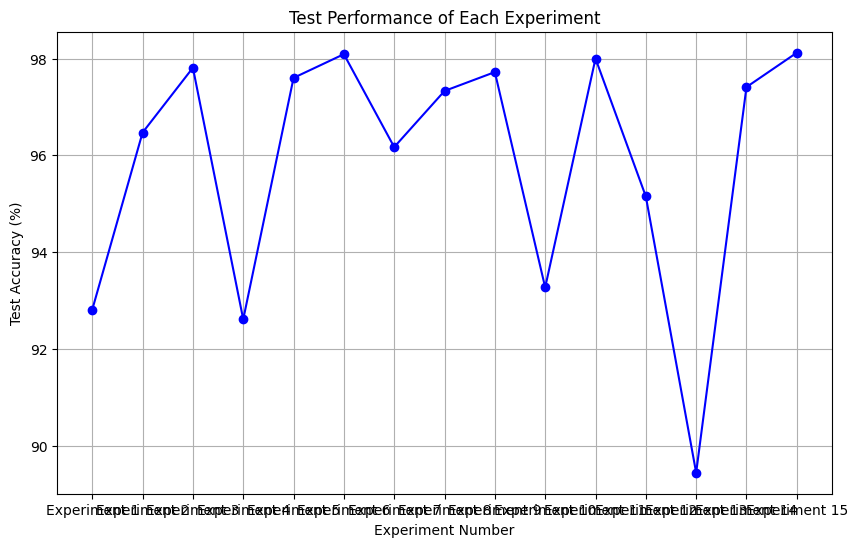

In [307]:
file_path = 'results1.xlsx' 
data = pd.read_excel(file_path)

print(data.head())

plt.figure(figsize=(10, 6))
plt.plot(data['Experiment'], data['Accuracy'], marker='o', linestyle='-', color='b')
plt.xlabel('Experiment Number')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Performance of Each Experiment')
plt.grid(True)
plt.show()

# Task2 Graph

     Experiment  Layers Hidden Layer Sizes  Batch Size  Learning Rate  \
0  Experiment 1       2             64, 32          64         0.0030   
1  Experiment 2       2             64, 32          64         0.0010   
2  Experiment 3       2            128, 64          64         0.0005   
3  Experiment 4       3         64, 32, 16          64         0.0020   
4  Experiment 5       3        128, 64, 32          64         0.0002   

  Optimizer  Accuracy            Training Data Division  
0       SGD     86.37  60,000 Training / 10,000 Testing  
1      Adam     86.99  60,000 Training / 10,000 Testing  
2   RMSprop     87.54  60,000 Training / 10,000 Testing  
3       SGD     85.17  60,000 Training / 10,000 Testing  
4      Adam     86.97  60,000 Training / 10,000 Testing  


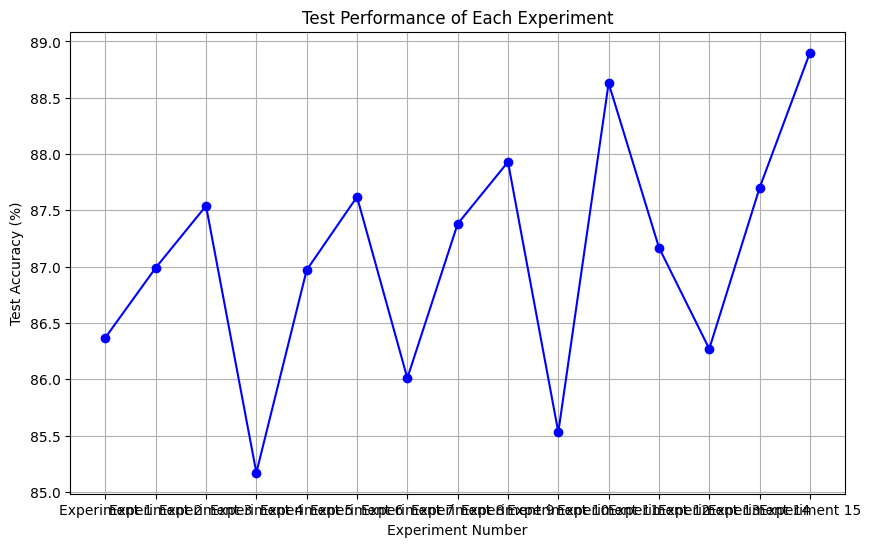

In [308]:
file_path = 'results2.xlsx' 
data = pd.read_excel(file_path)

print(data.head())

plt.figure(figsize=(10, 6))
plt.plot(data['Experiment'], data['Accuracy'], marker='o', linestyle='-', color='b')
plt.xlabel('Experiment Number')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Performance of Each Experiment')
plt.grid(True)
plt.show()

# Task3 Graph

     Experiment  Layers  Kernel Depth            Training Data Division  \
0  Experiment 1       8            96  60,000 Training / 10,000 Testing   
1  Experiment 2       8           192  60,000 Training / 10,000 Testing   
2  Experiment 3       8           224  60,000 Training / 10,000 Testing   
3  Experiment 4       7           128  60,000 Training / 10,000 Testing   
4  Experiment 5       7           256  60,000 Training / 10,000 Testing   

   Batch Size  Learning Rate Optimizer   Accuracy  
0          32         0.0040       SGD  86.790001  
1          64         0.0010      Adam  91.149998  
2          48         0.0050       SGD  86.390001  
3          32         0.0003      Adam  90.280002  
4          64         0.0200       SGD  88.590002  


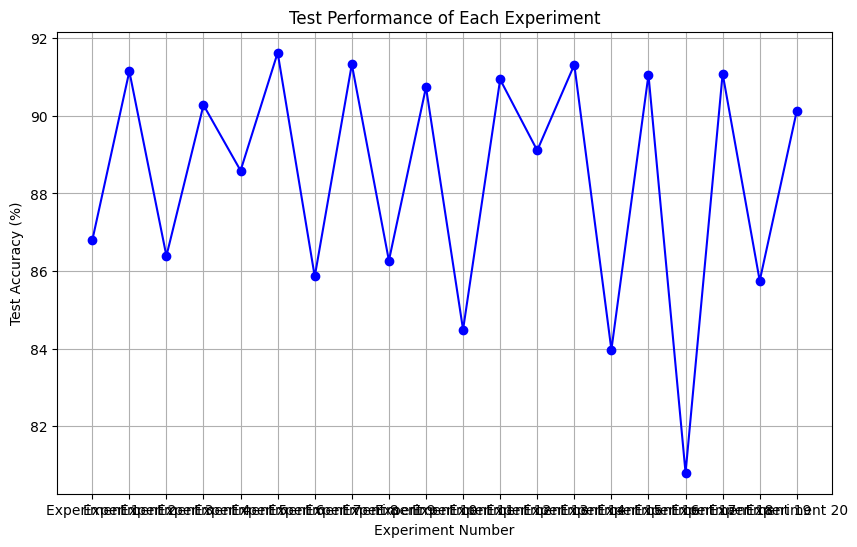

In [324]:
file_path = 'results3.xlsx' 
data = pd.read_excel(file_path)

print(data.head())

plt.figure(figsize=(10, 6))
plt.plot(data['Experiment'], data['Accuracy'], marker='o', linestyle='-', color='b')
plt.xlabel('Experiment Number')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Performance of Each Experiment')
plt.grid(True)
plt.show()